# Car Price prediction

## Прогнозирование стоимости автомобиля по характеристикам
В этом задании нужно спрогнозировать, сколько будет стоить автомобиль.
Учебное задание:
- провести анализ данных;
- построить модели и подать в них правильные данные 
- обработать изображения и текстовые описания для корректной работы с моделью.

## В baseline мы сделаем следующее:
* Построим "наивную"/baseline модель, предсказывающую цену по модели и году выпуска (с ней будем сравнивать другие модели)
* Обработаем и отнормируем признаки
* Сделаем первую модель на основе градиентного бустинга с помощью CatBoost
* Сделаем вторую модель на основе нейронных сетей и сравним результаты
* Сделаем multi-input нейронную сеть для анализа табличных данных и текста одновременно
* Добавим в multi-input сеть обработку изображений
* Осуществим ансамблирование градиентного бустинга и нейронной сети (усреднение их предсказаний)

In [1]:
#!pip install -q tensorflow

In [2]:
#аугментации изображений
!pip install albumentations -q

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import seaborn as sns
import random
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler

# # keras

import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import albumentations


# plt
import matplotlib.pyplot as plt
# увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
# графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg'
%matplotlib inline


# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.10 | packaged by conda-forge | (default, Sep 13 2021, 19:43:44) 
Numpy        : 1.19.5
Tensorflow   : 2.6.0


In [5]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [6]:
'''Простенькая функция для краткого описания признака'''


def sign_study(column):
    print(data[column].value_counts())
    print(data[column].isna().sum())
    if column in numerical_features:
        data[column].hist()
    elif column in binary_features:
        plt.figure(figsize=(6, 4))
        sns.countplot(data[column])
        plt.title(f"Распределение признака {column}")
    else:
        plt.figure(figsize=(6, 4))
        sns.countplot(y=data[column])
        plt.title(f"Распределение признака {column}")

In [7]:
'''Функция для перевода числовых значений в категориальные'''


def sign_to_cat(column):
    if column <= perc25:
        column = '0'
        return column
    if perc25 < column <= perc50:
        column = '1'
        return column
    if perc50 < column <= perc75:
        column = '2'
        return column
    if column > perc75:
        column = '3'
        return column

In [8]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [9]:
!pip freeze > requirements.txt

# DATA

Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [10]:
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [12]:
train.nunique()

bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
price                   1628
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
dtype: int64

# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



In [13]:
# split данных
data_train, data_test = train_test_split(train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [14]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == {row[1]}"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

# оцениваем точность
print(
    f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


# EDA

Проведем быстрый анализ данных для того, чтобы понимать, сможет ли с этими данными работать наш алгоритм.

Посмотрим, как выглядят распределения числовых признаков:

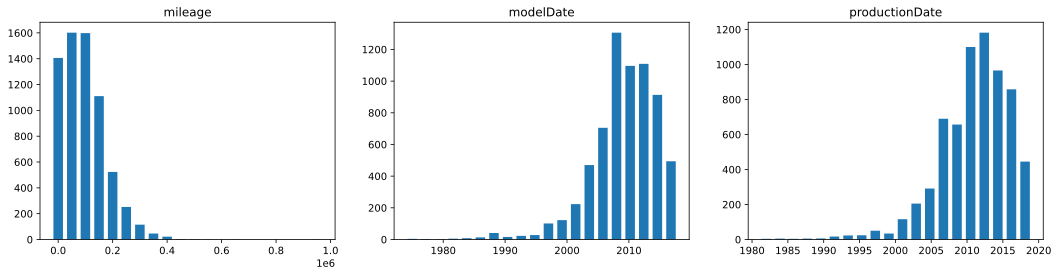

In [15]:
# посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
    columns = min(3, len(titles_values_dict))
    rows = (len(titles_values_dict) - 1) // columns + 1
    fig = plt.figure(figsize=(columns * 6, rows * 4))
    for i, (title, values) in enumerate(titles_values_dict.items()):
        hist, bins = np.histogram(values, bins=20)
        ax = fig.add_subplot(rows, columns, i + 1)
        ax.bar(bins[:-1], hist, width=(bins[1] - bins[0]) * 0.7)
        ax.set_title(title)
    plt.show()


visualize_distributions({
    'mileage': train['mileage'].dropna(),
    'modelDate': train['modelDate'].dropna(),
    'productionDate': train['productionDate'].dropna()
})

Итого:
* CatBoost сможет работать с признаками и в таком виде, но для нейросети нужны нормированные данные.

# PreProc Tabular Data

In [16]:
# используем все текстовые признаки как категориальные без предобработки
categorical_features = ['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower', 'fuelType', 'model_info', 'name',
                        'numberOfDoors', 'vehicleTransmission', 'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль']

# используем все числовые признаки
numerical_features = ['mileage', 'modelDate', 'productionDate']

# добавим новый список для бинарных признаков, если они у нас появятся
binary_features = []

In [17]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1  # помечаем где у нас трейн
test['sample'] = 0  # помечаем где у нас тест
# в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями
test['price'] = 0

data = test.append(train, sort=False).reset_index(drop=True)  # объединяем
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


In [18]:
data.isnull().sum()

bodyType                   0
brand                      0
color                      0
description                0
engineDisplacement         0
enginePower                0
fuelType                   0
mileage                    0
modelDate                  0
model_info                 0
name                       0
numberOfDoors              0
productionDate             0
sell_id                    0
vehicleConfiguration       0
vehicleTransmission        0
Владельцы                  1
Владение                5418
ПТС                        0
Привод                     0
Руль                       0
sample                     0
price                      0
dtype: int64

# Признаки старые и новые

Рассмотрим внимательнее имеющиеся в датасете признаки и, если получится, создадим на их основе новые. В этой части мы постараемся максимально расширить палитру понятных признаков отбора, чтобы потом регулировать их подачу в модели.

**Владение**

1 год и 8 месяцев     67
1 год и 2 месяца      67
1 год                 55
9 месяцев             52
2 года и 2 месяца     52
                      ..
17 лет и 4 месяца      1
15 лет и 3 месяца      1
13 лет и 3 месяца      1
11 лет и 1 месяц       1
23 года и 4 месяца     1
Name: Владение, Length: 180, dtype: int64
5418


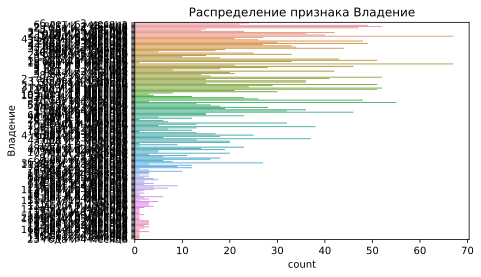

In [19]:
sign_study('Владение')

In [20]:
data['Владение'].value_counts()

1 год и 8 месяцев     67
1 год и 2 месяца      67
1 год                 55
9 месяцев             52
2 года и 2 месяца     52
                      ..
17 лет и 4 месяца      1
15 лет и 3 месяца      1
13 лет и 3 месяца      1
11 лет и 1 месяц       1
23 года и 4 месяца     1
Name: Владение, Length: 180, dtype: int64

In [21]:
print('В признаке Владение {}% пропущенных значений'.format(
    round(data['Владение'].isna().sum()/len(data['Владение'])*100)))

В признаке Владение 65% пропущенных значений


В этом признаке очень много пропусков, да и особо ценного смысла в нем нет - слишком много значений. Удалим.

In [22]:
data.drop(['Владение'], axis=1, inplace=True)

categorical_features.remove('Владение')

**Владельцы**

3 или более    3311
1 владелец     2526
2 владельца    2515
Name: Владельцы, dtype: int64
1


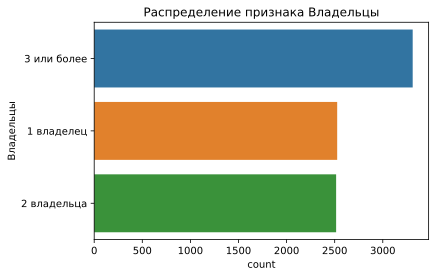

In [23]:
sign_study('Владельцы')

In [24]:
data['Владельцы'] = data['Владельцы'].fillna(data['Владельцы'].mode()[0])

3 или более    3312
1 владелец     2526
2 владельца    2515
Name: Владельцы, dtype: int64
0


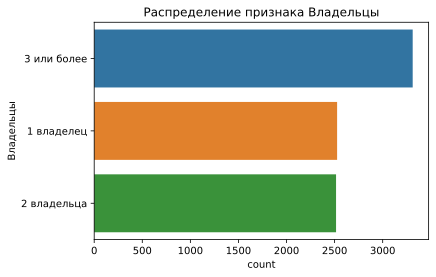

In [25]:
sign_study('Владельцы')

In [26]:
# Количество владельцев

# Обработаем данные, чтобы получить числа. У нас есть красивый категориальный признак!

data['Владельцы'] = data['Владельцы'].str.extract(
    '(\d)', expand=False).str.strip()

3    3312
1    2526
2    2515
Name: Владельцы, dtype: int64
0


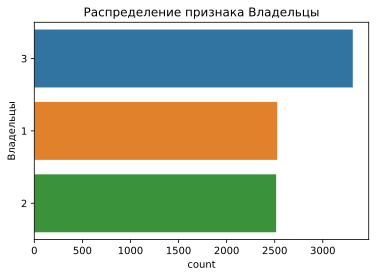

In [27]:
sign_study('Владельцы')

Выбросов в этом признаке не наблюдается, зато мы можем сделать вывод, что у бОльшей части автомобилей было три и более владельцев.

**Тип кузова**

седан                   3541
внедорожник 5 дв.       2896
купе                     543
хэтчбек 5 дв.            364
лифтбек                  299
универсал 5 дв.          196
минивэн                  178
купе-хардтоп             111
родстер                   88
хэтчбек 3 дв.             57
кабриолет                 54
компактвэн                 8
внедорожник 3 дв.          5
лимузин                    5
внедорожник открытый       4
пикап двойная кабина       3
седан 2 дв.                1
Name: bodyType, dtype: int64
0


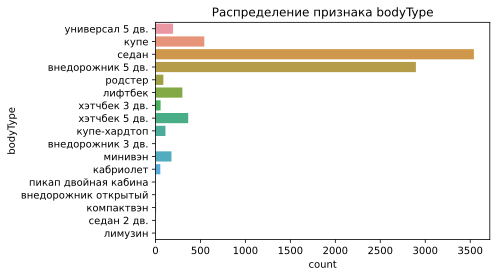

In [28]:
sign_study('bodyType')

In [29]:
# Приведем названия типов к единообразию, выбрав только первые элементы:
data['bodyType'] = data['bodyType'].astype(str).apply(
    lambda x: None if x.strip() == '' else x)
data['bodyType'] = data.bodyType.apply(lambda x: x.split(' ')[0].lower())

седан           3542
внедорожник     2905
купе             543
хэтчбек          421
лифтбек          299
универсал        196
минивэн          178
купе-хардтоп     111
родстер           88
кабриолет         54
компактвэн         8
лимузин            5
пикап              3
Name: bodyType, dtype: int64
0


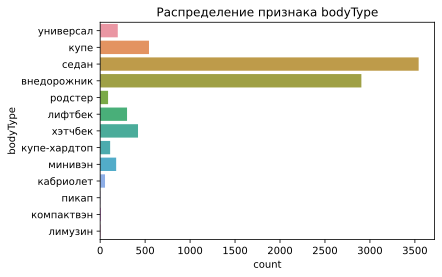

In [30]:
sign_study('bodyType')

Мы сократили размерность этого категориального признака, но можем его немного улучшить. Возьмем самые существенные значения, а остальные объединим под значением other

In [31]:
body = data.groupby(['bodyType']).size().reset_index(name='counts')
body_popular = body.loc[body.counts > 150]['bodyType'].unique()

In [32]:
for i in body['bodyType']:
    if i not in body_popular:
        data.loc[data['bodyType'] == i, 'bodyType'] = 'другое'

седан          3542
внедорожник    2905
купе            543
хэтчбек         421
лифтбек         299
другое          269
универсал       196
минивэн         178
Name: bodyType, dtype: int64
0


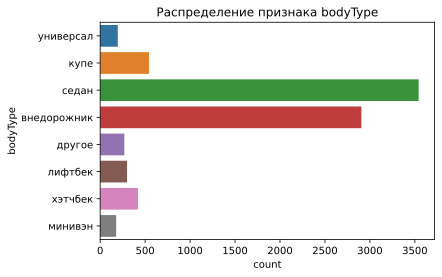

In [33]:
sign_study('bodyType')

**Марка**

BMW         3535
MERCEDES    2846
AUDI        1972
Name: brand, dtype: int64
0


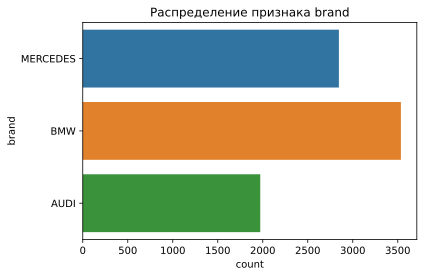

In [34]:
sign_study('brand')

Всего три бренда мы продаем, причем больше всего BMW. Оставляем без изменений

**Цвет**

чёрный         3468
белый          1607
серый           925
синий           863
серебристый     420
коричневый      386
красный         266
голубой          91
зелёный          86
бежевый          85
фиолетовый       46
пурпурный        38
оранжевый        30
золотистый       24
жёлтый           17
розовый           1
Name: color, dtype: int64
0


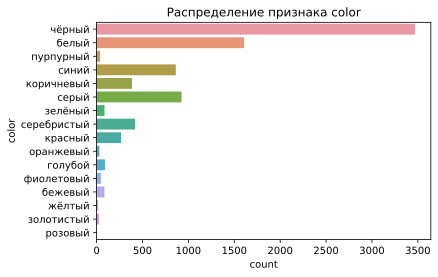

In [35]:
sign_study('color')

Самые популярные в продаже машины - черные и белые. Создадим новый бинарный признак "популярный цвет" и добавим его в список бинарных. Основной признак остается категориальным.

In [36]:
# Добавим в словарь самые популярные цвета
color_list = ['чёрный', 'белый']

#  Новый признак: популярный цвет - 1, остальные - 0
data['pop_color'] = data.color.apply(lambda x: 1 if x in color_list else 0)

1    5075
0    3278
Name: pop_color, dtype: int64
0


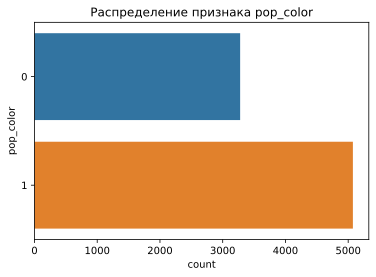

In [37]:
sign_study('pop_color')

Черные и белые машины лидируют с большим отрывом. Теперь сократим размерность основного признака тем же способом, что и для типов кузова.

In [38]:
colors = data.groupby(['color']).size().reset_index(name='counts')
colors_popular = colors.loc[colors.counts > 150]['color'].unique()

In [39]:
for i in colors['color']:
    if i not in colors_popular:
        data.loc[data['color'] == i, 'color'] = 'другое'

чёрный         3468
белый          1607
серый           925
синий           863
серебристый     420
другое          418
коричневый      386
красный         266
Name: color, dtype: int64
0


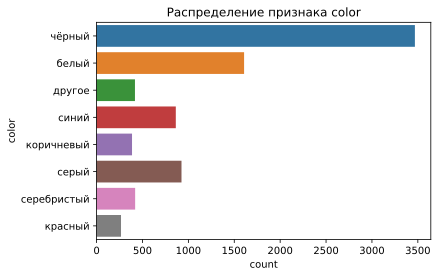

In [40]:
sign_study('color')

Мы сократили размерность, скрыли выбросы и сделали работу моделей немного проще. Не забудем добавить новый признак в списки.

In [41]:
binary_features.append('pop_color')

**Описание**

Описание - это сложный признак, который мы позже будем использовать в работе. Однако из него можно создать несколько приятных бинарных признаков. Например, попробовать отделить автомобили, которые продает салон, от тех, с которыми хочет расстаться частное лицо.

In [42]:
data['description'] = data['description'].map(lambda x: str(x).lower())

data['person'] = data['description'].apply(
    lambda x: 1 if 'торг' in x or 'не нуждаюсь' in x or len(x) < 200 else 0)
data['showroom'] = data['description'].apply(lambda x: 1 if 'traid-in' in x or 'дилер' in x or 'в кредит' in x or 'клиент' in x
                                             or 'без комис' in x or 'страховани' in x or 'трейд-ин' in x
                                             or 'в наличии' in x or 'выгодное пр' in x or 'автокредит' in x else 0)
display(data['person'].value_counts())
display(data['showroom'].value_counts())

0    4907
1    3446
Name: person, dtype: int64

0    4754
1    3599
Name: showroom, dtype: int64

0    4907
1    3446
Name: person, dtype: int64
0


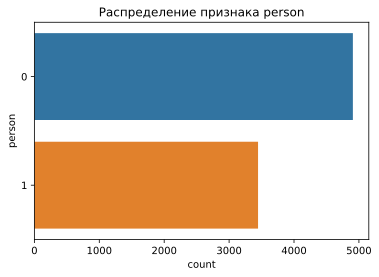

In [43]:
sign_study('person')

0    4754
1    3599
Name: showroom, dtype: int64
0


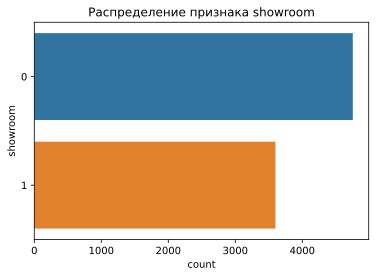

In [44]:
sign_study('showroom')

То, что у нас в обоих случаях получилось меньшее количество положительных результатов, объясняется тем, что в отрицательные вошли и те, которые мы не смогли определить по описанию.

Создадим еще несколько новых бинарных признаков, дающих представление о комплектации автомобиля.

In [45]:
data['new'] = data.description.apply(lambda x: 1 if 'нов' in x else 0)
data['tires'] = data.description.apply(
    lambda x: 1 if ('шины' in x) or ('резина' in x) else 0)
data['heating'] = data.description.apply(
    lambda x: 1 if 'подогрев сидений' in x else 0)
data['central_lock'] = data.description.apply(
    lambda x: 1 if 'центральный замок' in x else 0)
data['computer'] = data.description.apply(
    lambda x: 1 if 'бортовой компьютер' in x else 0)
data['airbag'] = data.description.apply(
    lambda x: 1 if 'подушки безопасности' in x else 0)
data['power_steering'] = data.description.apply(
    lambda x: 1 if 'усилитель руля' in x else 0)
data['cruise_control'] = data.description.apply(
    lambda x: 1 if 'круиз-контроль' in x else 0)
data['parktronic'] = data.description.apply(
    lambda x: 1 if 'парктроник' in x else 0)
data['child_car_seat'] = data.description.apply(
    lambda x: 1 if 'крепления детских автокресел' in x else 0)

In [46]:
binary_features = binary_features + ['person', 'showroom', 'new', 'tires', 'heating', 'central_lock',
                       'computer', 'airbag', 'power_steering', 'cruise_control', 'parktronic', 'child_car_seat']

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn

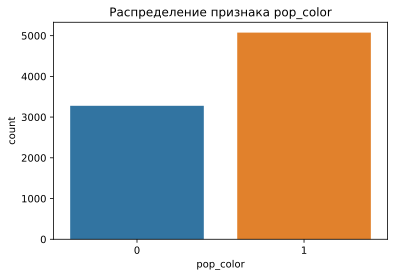

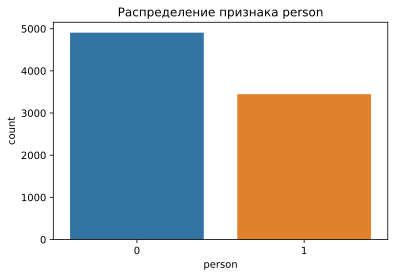

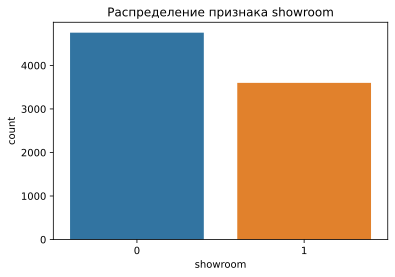

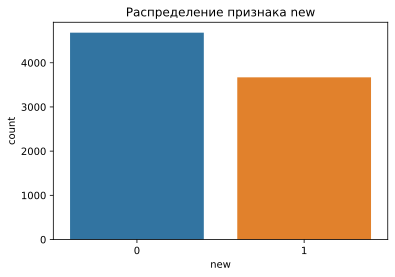

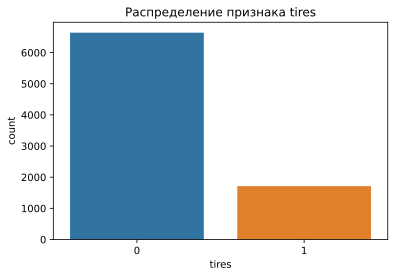

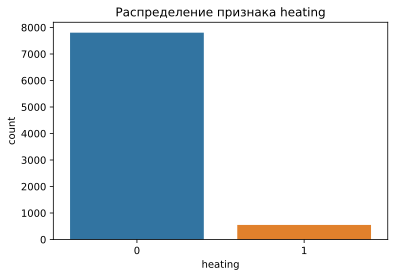

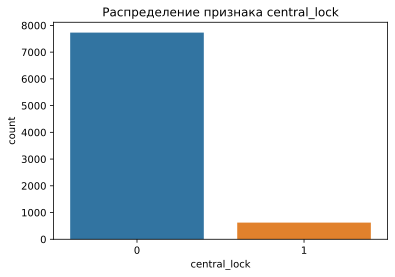

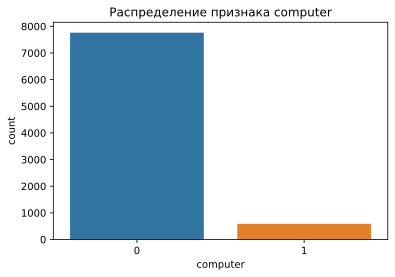

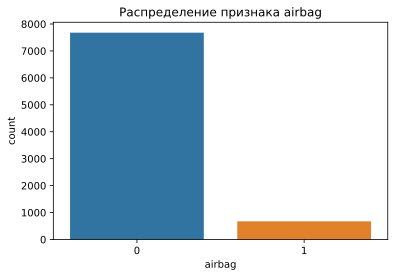

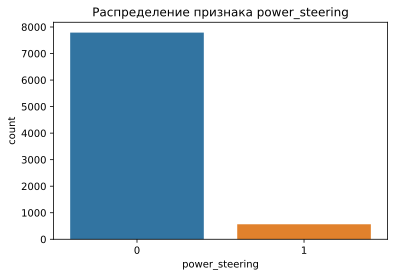

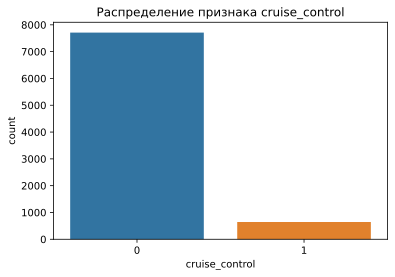

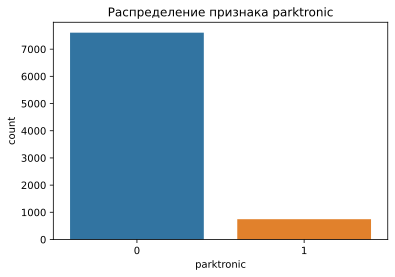

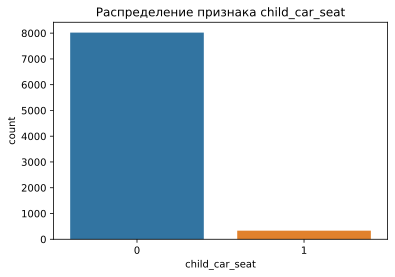

In [47]:
for col in binary_features:
    plt.figure(figsize=(6, 4))
    sns.countplot(data[col])
    plt.title(f"Распределение признака {col}")

**Вид топлива**

бензин     6018
дизель     2315
гибрид       14
электро       6
Name: fuelType, dtype: int64
0


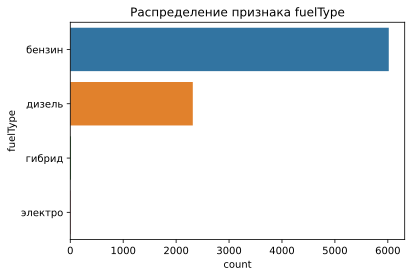

In [48]:
sign_study('fuelType')

Простой категориальный признак, не требующий обработки. Можем сократить размерность, но смысла в этом особого не видно.

Количество дверей

5    3854
4    3636
2     802
3      61
Name: numberOfDoors, dtype: int64
0


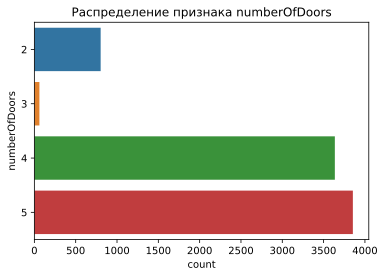

In [49]:
sign_study('numberOfDoors')

**Количество дверей**

5    3854
4    3636
2     802
3      61
Name: numberOfDoors, dtype: int64
0


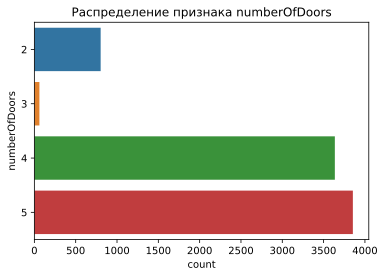

In [50]:
sign_study('numberOfDoors')

Простой категориальный признак, выбросов (необычных значений) нет. Оставим без изменений.

**Объем двигателя (engineDisplacement)**

2.0 LTR          2430
3.0 LTR          2349
1.8 LTR           411
1.6 LTR           410
4.4 LTR           329
5.5 LTR           268
3.5 LTR           250
2.5 LTR           248
2.1 LTR           221
4.0 LTR           153
4.7 LTR           137
2.8 LTR           106
1.4 LTR           106
4.2 LTR           103
5.0 LTR            74
1.5 LTR            73
3.2 LTR            60
2.2 LTR            58
4.8 LTR            57
2.9 LTR            50
2.4 LTR            44
3.1 LTR            44
6.2 LTR            40
6.0 LTR            37
5.4 LTR            33
1.2 LTR            33
1.3 LTR            32
2.7 LTR            24
4.1 LTR            23
3.6 LTR            23
1.7 LTR            15
2.3 LTR            14
3.7 LTR            14
5.2 LTR            13
5.9 LTR            11
2.6 LTR             9
undefined LTR       6
0.7 LTR             6
6.6 LTR             5
1.9 LTR             5
5.8 LTR             5
4.6 LTR             5
4.3 LTR             4
3.4 LTR             4
3.8 LTR             3
6.3 LTR   

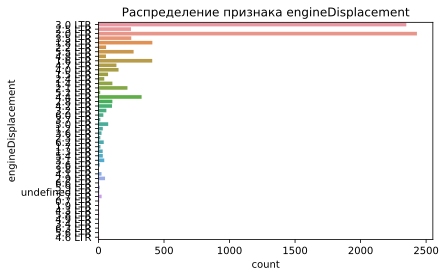

In [51]:
sign_study('engineDisplacement')

Тут сложнее. Очень много разных значений. Давайте разбираться.

In [52]:
data.engineDisplacement.unique()

array(['3.0 LTR', '2.5 LTR', '2.0 LTR', '3.5 LTR', '1.8 LTR', '2.2 LTR',
       '5.5 LTR', '4.8 LTR', '1.6 LTR', '4.7 LTR', '4.0 LTR', '1.5 LTR',
       '2.4 LTR', '1.4 LTR', '2.1 LTR', '5.2 LTR', '4.4 LTR', '2.8 LTR',
       '4.2 LTR', '3.2 LTR', '6.0 LTR', '3.7 LTR', '5.0 LTR', '1.2 LTR',
       '3.6 LTR', '2.3 LTR', '6.2 LTR', '1.7 LTR', '1.3 LTR', '5.4 LTR',
       '3.1 LTR', '2.6 LTR', '3.8 LTR', '4.1 LTR', '2.9 LTR', '6.6 LTR',
       '5.9 LTR', 'undefined LTR', '2.7 LTR', '0.7 LTR', '1.9 LTR',
       '4.3 LTR', '5.8 LTR', '4.9 LTR', '3.4 LTR', '6.3 LTR', '5.6 LTR',
       '4.6 LTR'], dtype=object)

In [53]:
# Значения надо почистить, для этого преобразуем их в строки:    
data['engineDisplacement'] = data['engineDisplacement'].astype(str)

In [54]:
# Извлечём из признака только числовые данные (объём двигателя в литрах) с помощью regex:
data['engineDisplacement'] = data['engineDisplacement'].str.extract(
    '(\d.\d)', expand=False).str.strip()

2.0    2430
3.0    2349
1.8     411
1.6     410
4.4     329
5.5     268
3.5     250
2.5     248
2.1     221
4.0     153
4.7     137
1.4     106
2.8     106
4.2     103
5.0      74
1.5      73
3.2      60
2.2      58
4.8      57
2.9      50
3.1      44
2.4      44
6.2      40
6.0      37
5.4      33
1.2      33
1.3      32
2.7      24
3.6      23
4.1      23
1.7      15
2.3      14
3.7      14
5.2      13
5.9      11
2.6       9
0.7       6
6.6       5
1.9       5
5.8       5
4.6       5
4.3       4
3.4       4
3.8       3
6.3       3
5.6       3
4.9       2
Name: engineDisplacement, dtype: int64
6


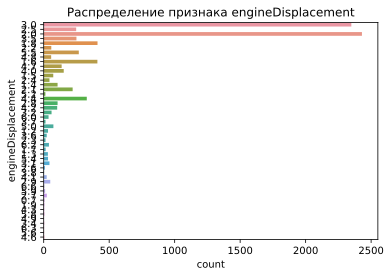

In [55]:
sign_study('engineDisplacement')

In [56]:
data['engineDisplacement'] = data['engineDisplacement'].fillna(0)

Появилось шесть пропусков, которые мы заполним нулями.

2.0    2430
3.0    2349
1.8     411
1.6     410
4.4     329
5.5     268
3.5     250
2.5     248
2.1     221
4.0     153
4.7     137
2.8     106
1.4     106
4.2     103
5.0      74
1.5      73
3.2      60
2.2      58
4.8      57
2.9      50
2.4      44
3.1      44
6.2      40
6.0      37
5.4      33
1.2      33
1.3      32
2.7      24
4.1      23
3.6      23
1.7      15
2.3      14
3.7      14
5.2      13
5.9      11
2.6       9
0         6
0.7       6
6.6       5
1.9       5
5.8       5
4.6       5
4.3       4
3.4       4
3.8       3
6.3       3
5.6       3
4.9       2
Name: engineDisplacement, dtype: int64
0


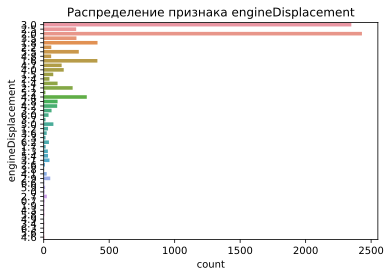

In [57]:
sign_study('engineDisplacement')

In [58]:
# После нескольких проб выяснилось, что лучше бы перевести этот признак в категориальный. Но на всякий случай сохраним и числовые значения

data['engineDisplacement_num'] = data['engineDisplacement'].astype('float')

# Разобьем значения по категориям:
data['engineDisplacement'] = data['engineDisplacement'].astype('float').apply(lambda x: 4 if x >= 4 else
                                                                              3 if x >= 3 else(2 if x >= 2 else (1 if x >= 1 else 0)))
data['engineDisplacement'].value_counts()

2    3204
3    2747
4    1305
1    1085
0      12
Name: engineDisplacement, dtype: int64

In [59]:
numerical_features.append('engineDisplacement_num')

2.0    2430
3.0    2349
1.8     411
1.6     410
4.4     329
5.5     268
3.5     250
2.5     248
2.1     221
4.0     153
4.7     137
2.8     106
1.4     106
4.2     103
5.0      74
1.5      73
3.2      60
2.2      58
4.8      57
2.9      50
2.4      44
3.1      44
6.2      40
6.0      37
5.4      33
1.2      33
1.3      32
2.7      24
4.1      23
3.6      23
1.7      15
2.3      14
3.7      14
5.2      13
5.9      11
2.6       9
0.0       6
0.7       6
6.6       5
1.9       5
5.8       5
4.6       5
4.3       4
3.4       4
3.8       3
6.3       3
5.6       3
4.9       2
Name: engineDisplacement_num, dtype: int64
0


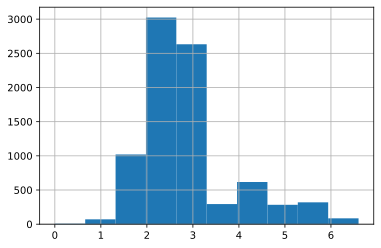

In [60]:
sign_study('engineDisplacement_num')

**Мощность двигателя (enginePower)**

184 N12    759
249 N12    655
190 N12    420
245 N12    355
306 N12    344
          ... 
520 N12      1
132 N12      1
430 N12      1
591 N12      1
174 N12      1
Name: enginePower, Length: 154, dtype: int64
0


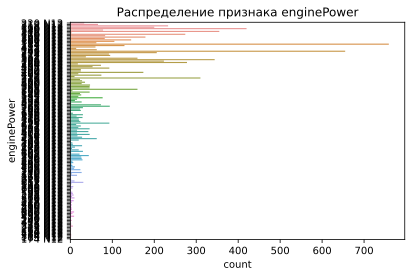

In [61]:
sign_study('enginePower')

Снова придется обрабатывать - приводить к числовому виду.

In [62]:
categorical_features.remove('enginePower')
numerical_features.append('enginePower')

In [63]:
data['enginePower'] = data['enginePower'].astype(
    str).apply(lambda x: x.split()[0])
data['enginePower'] = data['enginePower'].astype(float)

184.0    759
249.0    655
190.0    420
245.0    355
306.0    344
        ... 
520.0      1
132.0      1
430.0      1
591.0      1
174.0      1
Name: enginePower, Length: 154, dtype: int64
0


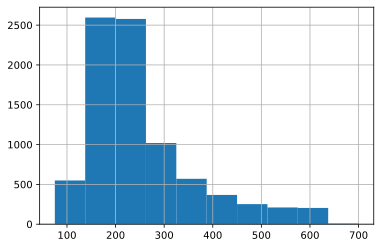

In [64]:
sign_study('enginePower')

<AxesSubplot:>

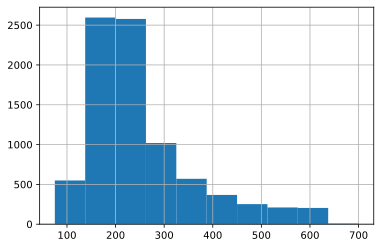

In [65]:
data['enginePower'].hist()

Для нормализации распределения этот признак стоит впоследствии логарифмировать.

**Пробег**

120000    79
150000    79
180000    77
130000    70
140000    62
          ..
56255      1
98100      1
11300      1
16858      1
21291      1
Name: mileage, Length: 3507, dtype: int64
0


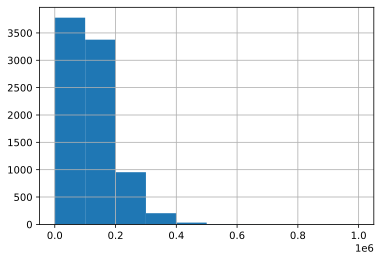

In [66]:
sign_study('mileage')

Распределение не нормальное, надо будет логарифмировать. Но сначала посмотрим, что мы можем понять и сделать из этого признака.

In [67]:
data['mileage'].describe()

count       8353.000000
mean      120362.983479
std        81856.639133
min            1.000000
25%        59246.000000
50%       110384.000000
75%       167084.000000
max      1000000.000000
Name: mileage, dtype: float64

Когда выпущены автомобили с минимальным пробегом и сколько их?

In [68]:
display(data.loc[data['mileage'] == 1.0].productionDate.unique())
display(len(data.loc[data['mileage'] == 1.0]))

array([2020, 2018, 2019])

8

Выглядит нормально, не считаем выбросами: год выпуска достаточно свежий (для этого датасета), а количество незначительное.

In [69]:
# введем новый категориальный признак - стадии пробега

perc25 = data['mileage'].quantile(0.25)
perc50 = data['mileage'].quantile(0.5)
perc75 = data['mileage'].quantile(0.75)
data['mileage_cat'] = data['mileage'].map(sign_to_cat)

In [70]:
categorical_features.append('mileage_cat')

0    2089
3    2088
2    2088
1    2088
Name: mileage_cat, dtype: int64
0


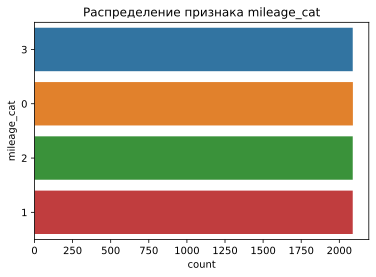

In [71]:
sign_study('mileage_cat')

Пока не логарифмируем признак, он нам еще понадобится.

**Дата выпуска модели и дата выпуска конкретного автомобиля**

2011    830
2013    739
2014    667
2015    656
2009    655
2008    562
2012    548
2007    542
2016    467
2010    407
2006    345
2005    321
2017    298
2004    242
2018    234
2003    146
2002    135
2019     82
2000     80
2001     76
1999     58
1998     56
1990     48
1994     31
1995     25
1997     16
1996     15
1992     14
1987     11
1984     10
1985      7
1989      5
1982      5
1979      4
1991      4
1975      2
1988      2
1981      2
1977      2
1971      1
1993      1
1986      1
1976      1
Name: modelDate, dtype: int64
0


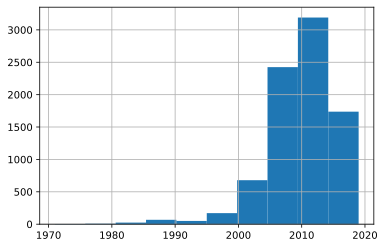

In [72]:
sign_study('modelDate')

Распределение ненормальное, сдвинуто вправо. Но мы потом его логарифмируем.


Для модели совершенно нормально иметь год выпуска 1976 и даже 1971. Полагаем, что это не выбросы.

<AxesSubplot:>

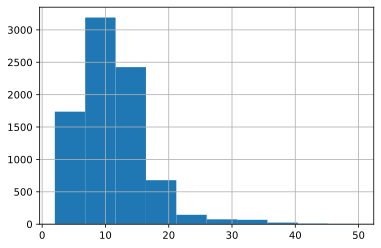

In [73]:
# Сделаем из года выпуска модели возраст модели

data['modelDate'] = 2021 - data['modelDate']
data['modelDate'].hist()

2013    783
2011    702
2014    693
2012    680
2016    600
2015    599
2017    562
2018    529
2008    510
2010    468
2019    449
2009    345
2007    343
2006    182
2005    170
2004    155
2020    100
2003    100
2002     78
2001     73
1999     45
2000     43
1998     24
1997     21
1994     15
1995     14
1992     12
1996     12
1993     12
1990     10
1986      4
1985      4
1988      4
1984      3
1982      3
1983      2
1991      2
1987      1
1989      1
Name: productionDate, dtype: int64
0


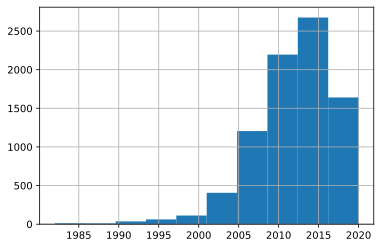

In [74]:
sign_study('productionDate')

Та же самая история. Давайте сделаем из этого признака несколько новых.

In [75]:
# разложим машины по категориям возраста. Новый признак добавим в категориальные

'''
def product_age(x):
    if x > 2017: x = 1
    elif 2018 > x > 2015: x = 2
    elif 2016 > x > 2013: x = 3
    elif 2014 > x > 2004: x = 4
    elif 2005 > x: x = 5
    return x  
'''
perc25 = data['productionDate'].quantile(0.25)
perc50 = data['productionDate'].quantile(0.5)
perc75 = data['productionDate'].quantile(0.75)
data['age_cat'] = data['productionDate'].map(sign_to_cat)

In [76]:
categorical_features.append('age_cat')

1    2633
0    2188
2    1892
3    1640
Name: age_cat, dtype: int64
0


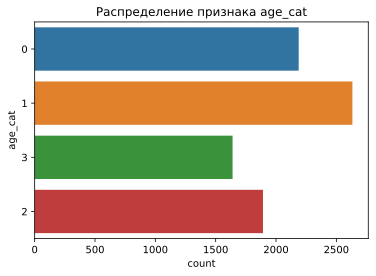

In [77]:
sign_study('age_cat')

Из даты выпуска сделаем возраст машины:

<AxesSubplot:>

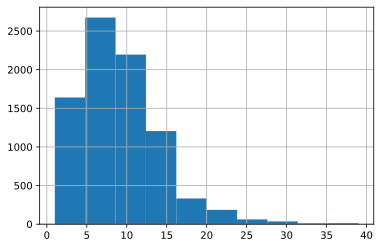

In [78]:
data['productionDate'] = 2021 - data['productionDate']
data['productionDate'].hist()

На основе признаков возраста и пробега можно сделать парочку новых числовых признаков. Например, сколько в среднем километров в год прошла машина. 

In [79]:
data['miles_per_year'] = round(data.mileage/data['productionDate'], 2)
numerical_features.append('miles_per_year')

15000.00    91
13000.00    60
20000.00    58
10000.00    56
12000.00    52
            ..
6208.33      1
17019.60     1
12397.90     1
19838.88     1
851.64       1
Name: miles_per_year, Length: 4563, dtype: int64
0


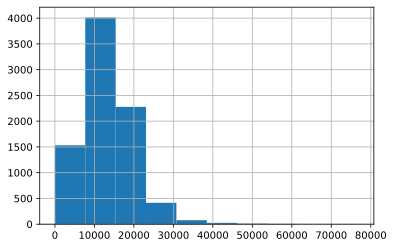

In [80]:
sign_study('miles_per_year')

А на основе этого посчитаем, совсем машина изношена или не очень:

In [81]:
data['hard_usage'] = data['miles_per_year'].apply(
    lambda x: 1 if x >= 20000 else 0)
binary_features.append('hard_usage')

0    7261
1    1092
Name: hard_usage, dtype: int64
0


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


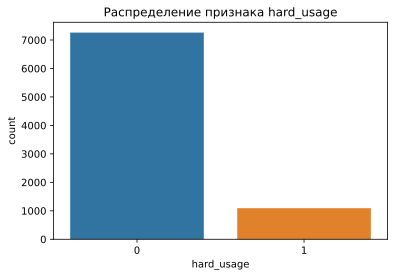

In [82]:
sign_study('hard_usage')

Нет уверенности, что это будет нужный признак. Для того, чтобы не забыть, какие колонки у нас под сомнением (при настройке модели мы сможем их удалить), заведем отдельный список:

In [83]:
doubt_features = []
doubt_features.append('hard_usage')

**Наличие ПТС**

Оригинал    7474
Дубликат     879
Name: ПТС, dtype: int64
0


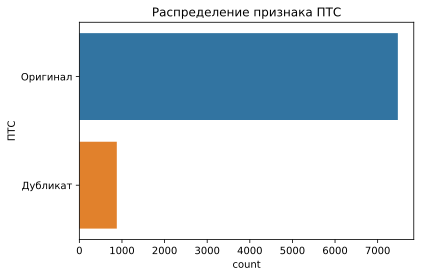

In [84]:
sign_study('ПТС')

**Модель**

5ER         776
3ER         578
X5          501
E_KLASSE    490
A6          433
           ... 
None          1
Z8            1
COUPE         1
Z3M           1
W201          1
Name: model_info, Length: 122, dtype: int64
0


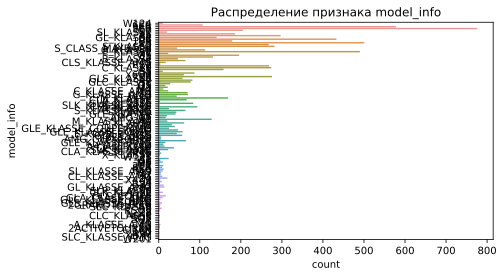

In [85]:
sign_study('model_info')

**Коробка передач (vehicleTransmission)**

автоматическая      6560
роботизированная    1201
вариатор             406
механическая         186
Name: vehicleTransmission, dtype: int64
0


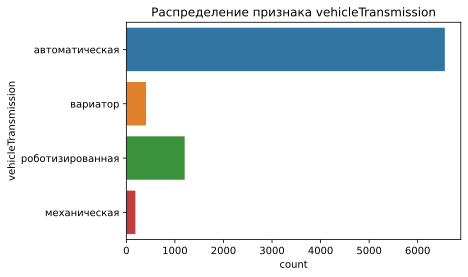

In [86]:
sign_study('vehicleTransmission')

**Руль**

Левый     8351
Правый       2
Name: Руль, dtype: int64
0


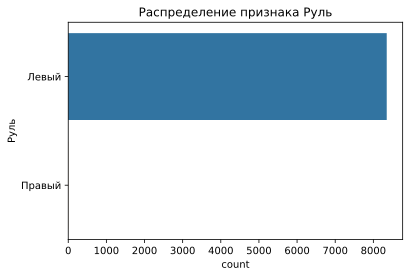

In [87]:
sign_study('Руль')

In [88]:
# Скорее всего, этот признак окажется не важным для модели, и его надо будет удалить при настройке.

doubt_features.append('Руль')

**Привод**

полный      5218
задний      2259
передний     876
Name: Привод, dtype: int64
0


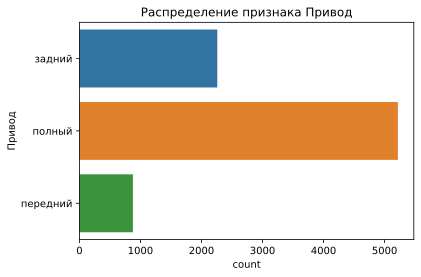

In [89]:
sign_study('Привод')

**Vehicle сonfiguration**

Попробуем токенизировать этот признак

In [90]:
import string
from nltk.corpus import stopwords
from nltk import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')
english_stopwords = stopwords.words("english")

print(string.punctuation)

spec_chars = string.punctuation + '«»—…’‘”“©'
print(spec_chars)

# Зададим функцию для удаления спец символов


def remove_chars_from_text(text, chars):
    return "".join([ch for ch in text if ch not in chars])

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~«»—…’‘”“©


In [91]:
english_stopwords = english_stopwords + \
    ['лс', 'квт', 'xdrive', 'wd', '4wd',  'xi']

In [92]:
# Зададим функцию для токенизации
def text_tokenizer(text):
    Text_ = text.strip()

    Text_ = Text_.lower()

    # Удалим все спец символы
    Text_ = remove_chars_from_text(Text_, spec_chars)

    # Удалим все цифры
    Text_ = remove_chars_from_text(Text_, string.digits)

    Text_ = Text_.replace('\n',' ').replace('\t',' ')

    # Токенизируем текст
    tokens = word_tokenize(Text_)

    # Список токенов преобразовываем к классу Text
    token_text = nltk.Text(tokens)

    # Удаляем стоп-слова
    filtered_token_text = [w for w in token_text if not w in english_stopwords]
    
    return filtered_token_text

In [93]:
data['vehicleConfiguration'] = data['vehicleConfiguration'].apply(
    lambda x: text_tokenizer(x))

In [94]:
data['vehicleConfiguration'] = data['vehicleConfiguration'].apply(
    lambda x: str(x).replace('[', '').replace(']', ''))

In [95]:
categorical_features.append('vehicleConfiguration')

**Name**

35i 3.0 AT (306 л.с.) 4WD          151
2.0 AMT (211 л.с.) 4WD             145
200 2.0 AT (184 л.с.)              137
30d 3.0d AT (249 л.с.) 4WD         109
400 3.0 AT (333 л.с.) 4WD           97
                                  ... 
300 3.0d AT (190 л.с.) 4WD           1
111 CDI L3 2.2d MT (116 л.с.)        1
200 2.0 AT (136 л.с.)                1
320 Long 3.0d AT (211 л.с.) 4WD      1
Pullman 6.0 AT (394 л.с.)            1
Name: name, Length: 976, dtype: int64
0


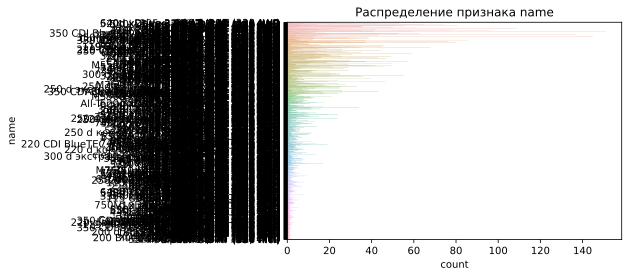

In [96]:
sign_study('name')

Из признака 'name' мы можем извлечь некоторые категориальные признаки. 

In [97]:
# Добавим признаки полного привода
data['4wd'] = data['name'].apply(lambda x: 1 if '4WD' in x else 0)
data['xdrive'] = data['name'].apply(lambda x: 1 if 'xDrive' in x else 0)

In [98]:
binary_features = binary_features + ['4wd', 'xdrive']

Попробуем токенизировать этот признак и посмотрим, что выйдет.

In [99]:
%% time

data['name'] = data['name'].apply(lambda x: text_tokenizer(x))

CPU times: user 855 ms, sys: 0 ns, total: 855 ms
Wall time: 855 ms


In [100]:
data['name'] = data['name'].apply(
    lambda x: str(x).replace('[', '').replace(']', ''))

In [101]:
categorical_features.append('name')

Теперь добавим среднюю цену за модели, марки, типа кузов, мощности и объема двигателя и сделаем эти цены новыми признаками. 

In [102]:
for col in ['model_info', 'brand', 'bodyType', 'engineDisplacement', 'enginePower']:
    col_means = data.groupby([col])['price'].mean().to_dict()
    data[col + '_' +
         'price'] = data[col].apply(lambda x: np.log(col_means[x]+1))

In [103]:
numerical_features = numerical_features + ['model_info_price', 'brand_price', 'bodyType_price',
                                           'engineDisplacement_price', 'enginePower_price']

# Обработка признаков

Обработаем бинарные и категориальные признаки, чтобы было легче их анализировать и использовать в моделях

In [104]:
label_encoder = LabelEncoder()
for i in binary_features:
    data[i] = label_encoder.fit_transform(data[i])

In [105]:
for column in categorical_features:
    data[column] = data[column].astype('category').cat.codes

Удалим лишнее:

# Анализ признаков

Изучим признаки - в том числе их влияние на цену

**Бинарные признаки**

Text(0.5, 1.0, 'Значимость бинарных признаков')

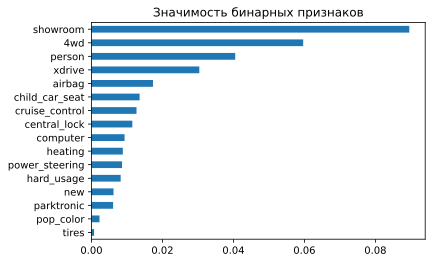

In [106]:
from sklearn.feature_selection import mutual_info_regression
from pandas import Series

imp_bin = Series(mutual_info_regression(data[binary_features], data['price'],
                                        discrete_features=True), index=binary_features)
imp_bin.sort_values(inplace=True)
imp_bin.plot(kind='barh')
plt.title('Значимость бинарных признаков')

Мы видим на этом графике значимость каждого признака для цены и сможем при регулировке модели использовать те из них, которые более важны.

In [107]:
doubt_features.append('tires')

<AxesSubplot:>

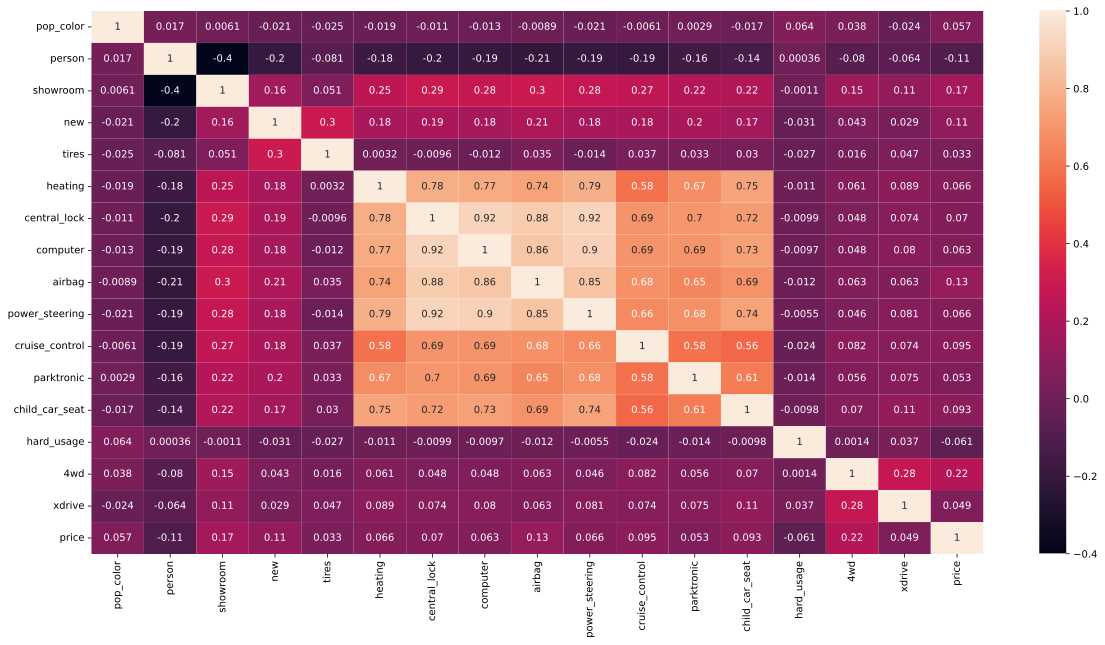

In [108]:
plt.figure(figsize=(20, 10))
sns.heatmap(data[binary_features+['price']].corr(), annot=True)

Мы видим, что ряд созданных искусственно признаков сильно коррелирует между собой. Можем удалить коррелирующие при настройке модели.

In [109]:
doubt_features = doubt_features + ['power_steering', 'central_lock', 'airbag']

**Числовые признаки**

Text(0.5, 1.0, 'Значимость числовых признаков')

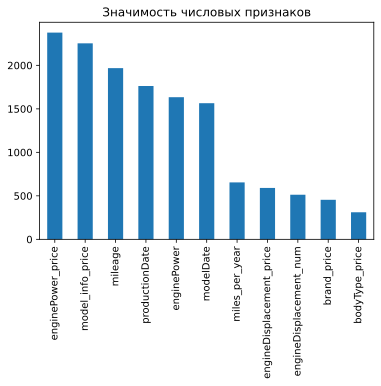

In [110]:
from sklearn.feature_selection import f_regression

imp_num = pd.Series(f_regression(data[numerical_features], data["price"])[
                    0], index=numerical_features)
imp_num.sort_values(inplace=True, ascending=False)
imp_num.plot(kind="bar")
plt.title('Значимость числовых признаков')

Практически все признаки являются значимыми для модели.

<AxesSubplot:>

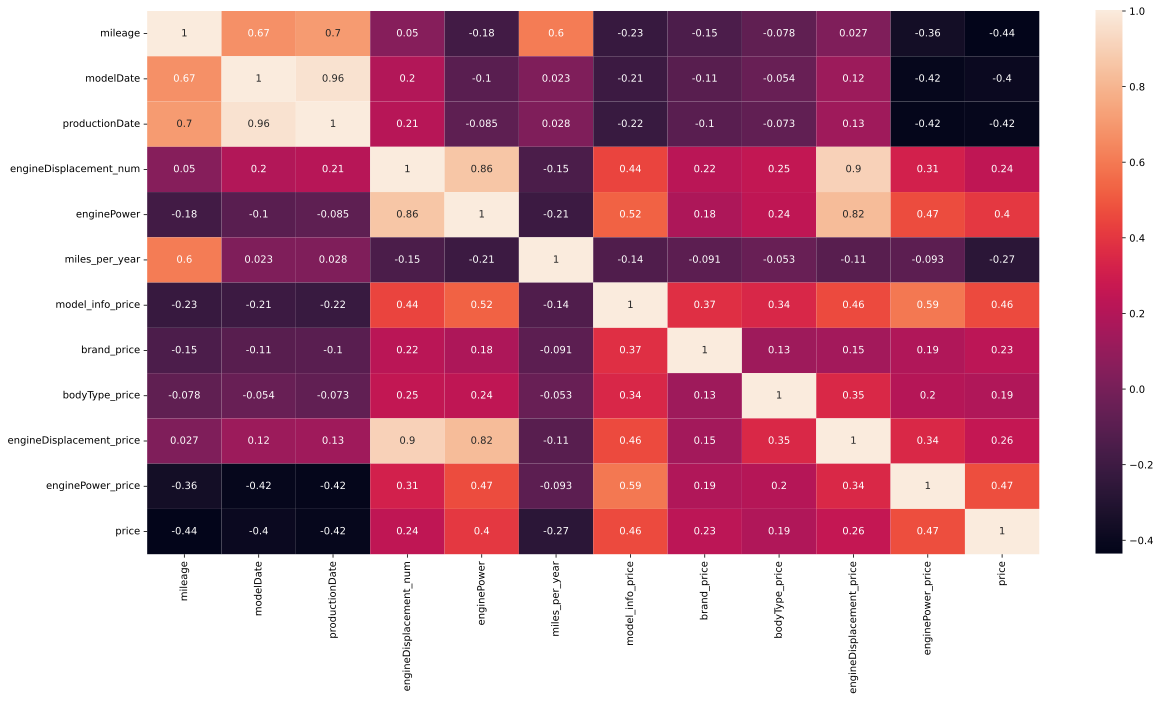

In [111]:
plt.figure(figsize=(20, 10))
sns.heatmap(data[numerical_features+['price']].corr(), annot=True)

Мы видим сильную корреляцию, и добавляем в список для настройки те признаки, которые считаем менее значимыми. Так, нам кажется, что возраст автомобиля важнее, чем возраст модели.

In [112]:
doubt_features = doubt_features + \
    ['modelDate', 'engineDisplacement_price', 'engineDisplacement_num']

**Категориальные признаки**

<AxesSubplot:>

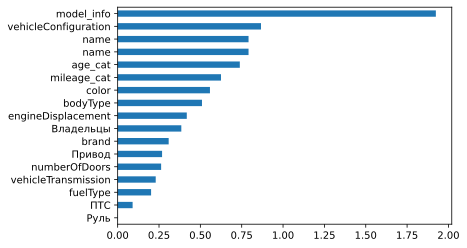

In [113]:
from sklearn.feature_selection import mutual_info_classif

temp_df = data[data['sample'] == 1]
imp_cat = Series(mutual_info_classif(temp_df[categorical_features],
                                     temp_df['price'], discrete_features=True),
                 index=categorical_features)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

А я говорила раньше, что "Руль" не пригодится...

<AxesSubplot:>

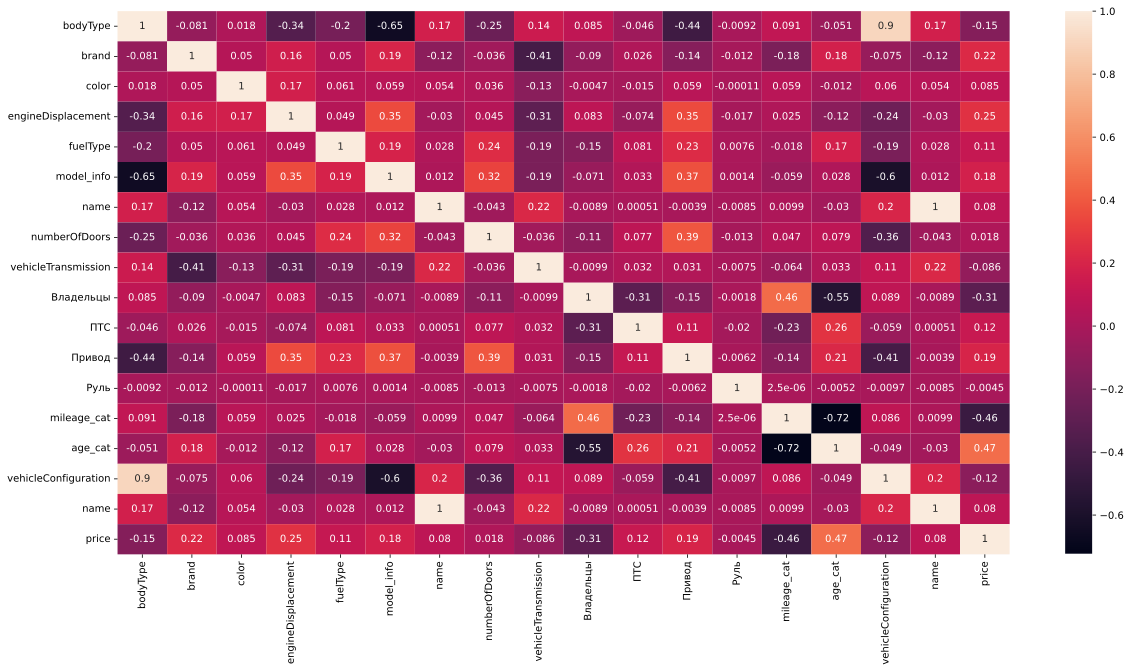

In [114]:
plt.figure(figsize=(20, 10))
sns.heatmap(data[categorical_features+['price']].corr(), annot=True)

Подозрительно близки к обратной корреляции категориальные признаки пробега и возраста модели (что объяснимо). Но оба они важны для модели, как подсказывает график выше. Крайне сильно коррелируют между собой тип кузова и конфигурация транспортного средства (даже после обработки)

In [115]:
doubt_features.append('vehicleConfiguration')

# Проверка всех внесенных изменений

In [116]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Data columns (total 47 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   bodyType                  8353 non-null   int8   
 1   brand                     8353 non-null   int8   
 2   color                     8353 non-null   int8   
 3   description               8353 non-null   object 
 4   engineDisplacement        8353 non-null   int8   
 5   enginePower               8353 non-null   float64
 6   fuelType                  8353 non-null   int8   
 7   mileage                   8353 non-null   int64  
 8   modelDate                 8353 non-null   int64  
 9   model_info                8353 non-null   int8   
 10  name                      8353 non-null   int8   
 11  numberOfDoors             8353 non-null   int8   
 12  productionDate            8353 non-null   int64  
 13  sell_id                   8353 non-null   int64  
 14  vehicleC

In [117]:
display(numerical_features)
display(binary_features)
display(categorical_features)

['mileage',
 'modelDate',
 'productionDate',
 'engineDisplacement_num',
 'enginePower',
 'miles_per_year',
 'model_info_price',
 'brand_price',
 'bodyType_price',
 'engineDisplacement_price',
 'enginePower_price']

['pop_color',
 'person',
 'showroom',
 'new',
 'tires',
 'heating',
 'central_lock',
 'computer',
 'airbag',
 'power_steering',
 'cruise_control',
 'parktronic',
 'child_car_seat',
 'hard_usage',
 '4wd',
 'xdrive']

['bodyType',
 'brand',
 'color',
 'engineDisplacement',
 'fuelType',
 'model_info',
 'name',
 'numberOfDoors',
 'vehicleTransmission',
 'Владельцы',
 'ПТС',
 'Привод',
 'Руль',
 'mileage_cat',
 'age_cat',
 'vehicleConfiguration',
 'name']

# Model 2: CatBoostRegressor

Подготовим данные для подачи в первую модель

In [118]:
print('Не забудь проверить при настройке, можно ли удалить следующие признаки:', doubt_features)

Не забудь проверить при настройке, можно ли удалить следующие признаки: ['hard_usage', 'Руль', 'tires', 'power_steering', 'central_lock', 'airbag', 'modelDate', 'engineDisplacement_price', 'engineDisplacement_num', 'vehicleConfiguration']


In [119]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''

    df_output = df_input.copy()

    # ################### 1. Предобработка ##############################################################
    # убираем не нужные для модели признаки
    df_output.drop(['description', 'sell_id', 'miles_per_year',
                    'Руль', 'hard_usage'], axis=1, inplace=True)

    numerical_features = ['mileage', 'productionDate', 'enginePower', 'engineDisplacement_num',
                          'model_info_price', 'modelDate', 'bodyType_price', 'brand_price']
    binary_features = ['pop_color', 'person', 'showroom', 'new', 'heating', 'central_lock', 'computer',
                       'airbag', 'parktronic', 'child_car_seat', '4wd', 'xdrive', 'cruise_control', 'power_steering']
    categorical_features = ['bodyType', 'brand', 'color', 'engineDisplacement', 'fuelType', 'model_info', 'numberOfDoors', 'vehicleTransmission', 'Владельцы',
                            'ПТС', 'Привод', 'mileage_cat', 'age_cat']

    # ################### Numerical Features ##############################################################
    # Далее заполняем пропуски
    for column in numerical_features:
        df_output[column].fillna(df_output[column].median(), inplace=True)
    # тут ваш код по обработке NAN
    # ....

    # Нормализация данных
    # scaler = MinMaxScaler()
    # for column in numerical_features:
    #    df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
    # for col in numerical_features:
    #    data[col] = np.log(data[col] + 1)

    scaler = RobustScaler()
    for column in numerical_features:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:, 0]

    # ################### Categorical Features ##############################################################
    # Label Encoding
    # for column in categorical_features:
    #    df_output[column] = df_output[column].astype('category').cat.codes

    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    # df_output = pd.get_dummies(df_output, columns=categorical_features + binary_features, dummy_na=False)
    # df_output = pd.get_dummies(df_output, columns=binary_features, dummy_na=False)
    # тут ваш код не Encoding фитчей
    # ....

    # ################### Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей

    # ################### Clean ####################################################
    # убираем признаки которые еще не успели обработать,
    # df_output.drop(['vehicleConfiguration'], axis = 1, inplace=True)

    return df_output

In [120]:
# Запускаем и проверяем, что получилось
df_preproc = preproc_data(data)
df_preproc.sample(10)

bodyType  brand  color  engineDisplacement  enginePower  fuelType  \
2859         2      1      7                   2    -0.106557         0   
2981         5      2      7                   2    -0.278689         0   
6697         5      0      7                   2    -0.254098         0   
5173         6      1      7                   2    -0.319672         0   
4795         5      1      7                   4     2.262295         0   
7419         5      1      7                   4     1.442623         0   
8195         5      2      1                   2    -0.303279         2   
4695         5      0      0                   3     0.483607         0   
5606         2      2      7                   1    -0.221311         0   
2714         2      1      0                   2    -0.614754         0   

       mileage  modelDate  model_info  name  ...  engineDisplacement_num  \
2859  0.001076   0.857143           5     0  ...                    -0.3   
2981 -0.675866  -0.714286          37     0  ...                    -0.8   
6697  0.525789   1.000000          13    27  ...                    -0.8   
5173  2.212726   1.428571           5     0  ...                    -0.3   
4795  0.367366   1.000000          61     8  ...                     2.2   
7419 -0.082336   0.428571           9    38  ...                     1.6   
8195 -0.550678  -0.714286          37     0  ...                    -0.8   
4695  0.052078   0.428571          16     0  ...                     0.2   
5606 -0.133385   0.000000          35     0  ...                    -1.0   
2714  1.146312   0.857143           5     0  ...                    -0.8   

      mileage_cat  age_cat  4wd  xdrive  model_info_price  brand_price  \
2859            2        0    1       0         -0.433264     0.000000   
2981            0        3    0       0          0.333353     1.000000   
6697            2        0    0       0         -0.924712    -0.756899   
5173            3        0    1       0         -0.433264     0.000000   
4795            2        0    0       0          1.887677     0.000000   
7419            1        1    1       1          0.817026     0.000000   
8195            0        2    0       0          0.333353     1.000000   
4695            2        1    1       0         -0.511417    -0.756899   
5606            1        1    0       0         -0.188549     1.000000   
2714            3        0    0       0         -0.433264     0.000000   

      bodyType_price  engineDisplacement_price  enginePower_price  
2859        0.539039                 14.056209          13.603088  
2981       -0.639530                 14.056209          14.454891  
6697       -0.639530                 14.056209          13.021282  
5173       -1.985318                 14.056209          13.500276  
4795       -0.639530                 14.729853          14.441421  
7419       -0.639530                 14.729853          13.714579  
8195       -0.639530                 14.056209          14.377729  
4695       -0.639530                 14.301208          13.588466  
5606        0.539039                 13.602671          13.840629  
2714        0.539039                 14.056209          13.529756  

[10 rows x 42 columns]

In [121]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Data columns (total 42 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   bodyType                  8353 non-null   int8   
 1   brand                     8353 non-null   int8   
 2   color                     8353 non-null   int8   
 3   engineDisplacement        8353 non-null   int8   
 4   enginePower               8353 non-null   float64
 5   fuelType                  8353 non-null   int8   
 6   mileage                   8353 non-null   float64
 7   modelDate                 8353 non-null   float64
 8   model_info                8353 non-null   int8   
 9   name                      8353 non-null   int8   
 10  numberOfDoors             8353 non-null   int8   
 11  productionDate            8353 non-null   float64
 12  vehicleConfiguration      8353 non-null   int8   
 13  vehicleTransmission       8353 non-null   int8   
 14  Владельц

**Split data**

In [122]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

In [123]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1671 entries, 0 to 1670
Data columns (total 41 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   bodyType                  1671 non-null   int8   
 1   brand                     1671 non-null   int8   
 2   color                     1671 non-null   int8   
 3   engineDisplacement        1671 non-null   int8   
 4   enginePower               1671 non-null   float64
 5   fuelType                  1671 non-null   int8   
 6   mileage                   1671 non-null   float64
 7   modelDate                 1671 non-null   float64
 8   model_info                1671 non-null   int8   
 9   name                      1671 non-null   int8   
 10  numberOfDoors             1671 non-null   int8   
 11  productionDate            1671 non-null   float64
 12  vehicleConfiguration      1671 non-null   int8   
 13  vehicleTransmission       1671 non-null   int8   
 14  Владельц

In [124]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [125]:
model = CatBoostRegressor(iterations=5000,
                          # depth=10,
                          #learning_rate = 0.5,
                          random_seed=RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                          # task_type='GPU',
                          )
model.fit(X_train, y_train,
          eval_set=(X_test, y_test),
          verbose_eval=100,
          use_best_model=True,
          # plot=True
          )

Learning rate set to 0.025058
0:	learn: 0.9880344	test: 1.0120323	best: 1.0120323 (0)	total: 54.6ms	remaining: 4m 32s
100:	learn: 0.2657448	test: 0.2644675	best: 0.2644675 (100)	total: 346ms	remaining: 16.8s
200:	learn: 0.1841860	test: 0.1852905	best: 0.1852905 (200)	total: 629ms	remaining: 15s
300:	learn: 0.1594932	test: 0.1618078	best: 0.1618078 (300)	total: 915ms	remaining: 14.3s
400:	learn: 0.1476587	test: 0.1505892	best: 0.1505892 (400)	total: 1.2s	remaining: 13.7s
500:	learn: 0.1407656	test: 0.1446765	best: 0.1446315 (498)	total: 1.48s	remaining: 13.3s
600:	learn: 0.1345828	test: 0.1397411	best: 0.1397411 (600)	total: 1.77s	remaining: 13s
700:	learn: 0.1300256	test: 0.1368153	best: 0.1367986 (699)	total: 2.06s	remaining: 12.6s
800:	learn: 0.1258826	test: 0.1341297	best: 0.1341297 (800)	total: 2.35s	remaining: 12.3s
900:	learn: 0.1228794	test: 0.1325058	best: 0.1325058 (900)	total: 2.64s	remaining: 12s
1000:	learn: 0.1205742	test: 0.1314331	best: 0.1314331 (1000)	total: 2.92s	rema

In [126]:
test_predict_catboost = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")

TEST mape: 11.85%


### Submission

In [127]:
sub_predict_catboost = model.predict(X_sub)
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv('catboost_submission.csv', index=False)

# Model 3: Tabular NN

In [128]:
print('Не забудь проверить при настройке, можно ли удалить следующие признаки:', doubt_features)

Не забудь проверить при настройке, можно ли удалить следующие признаки: ['hard_usage', 'Руль', 'tires', 'power_steering', 'central_lock', 'airbag', 'modelDate', 'engineDisplacement_price', 'engineDisplacement_num', 'vehicleConfiguration']


In [129]:
def preproc_data2(df_input):
    '''includes several functions to pre-process the predictor data.'''

    df_output = df_input.copy()

    # ################### 1. Предобработка ##############################################################
    # убираем не нужные для модели признаки
    df_output.drop(['description', 'sell_id', 'hard_usage',
                    'vehicleConfiguration', 'name'], axis=1, inplace=True)
    numerical_features = ['mileage', 'modelDate', 'productionDate', 'engineDisplacement_num', 'enginePower', 'miles_per_year', 'model_info_price', 'brand_price',
                          'bodyType_price', 'engineDisplacement_price', 'enginePower_price']
    binary_features = ['pop_color', 'person', 'showroom', 'new', 'tires', 'heating', 'central_lock', 'computer', 'airbag', 'power_steering', 'cruise_control',
                       'parktronic', 'child_car_seat', '4wd', 'xdrive']
    categorical_features = ['bodyType', 'brand', 'color', 'engineDisplacement', 'fuelType', 'model_info', 'numberOfDoors', 'vehicleTransmission', 'Владельцы',
                            'ПТС', 'Привод', 'mileage_cat', 'Руль', 'age_cat']

    # ################### Numerical Features ##############################################################
    # Далее заполняем пропуски
    for column in numerical_features:
        df_output[column].fillna(df_output[column].median(), inplace=True)
    # тут ваш код по обработке NAN
    # ....

    # Нормализация данных
    for col in numerical_features:
        data[col] = np.log(data[col] + 1)

    # scaler = MinMaxScaler()
    # for column in numerical_features:
    #    df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]

    scaler = RobustScaler()
    for column in numerical_features:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:, 0]

    # ################### Categorical Features ##############################################################
    # Label Encoding
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes

    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    df_output = pd.get_dummies(
        df_output, columns=categorical_features, dummy_na=False)
    df_output = pd.get_dummies(
        df_output, columns=binary_features, dummy_na=False)
    # тут ваш код не Encoding фитчей
    # ....

    # ################### Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    # ...

    # ################### Clean ####################################################
    # убираем признаки которые еще не успели обработать,
    # df_output.drop(['vehicleConfiguration'], axis = 1, inplace=True)

    return df_output

In [130]:
# Запускаем и проверяем, что получилось
df_preproc2 = preproc_data2(data)
df_preproc2.sample(10)

enginePower   mileage  modelDate  productionDate  sample      price  \
1071     0.614754  0.228268   0.285714        0.142857       0        0.0   
7999     0.204918  0.135537   0.428571        0.428571       1   990000.0   
2888    -0.500000  0.960849   0.857143        0.857143       1   510000.0   
7505    -0.106557 -0.281756  -0.285714       -0.571429       1  2640000.0   
982      0.893443  0.756839   0.285714        0.142857       0        0.0   
4308    -0.385246 -0.068473  -0.285714        0.000000       1  1180000.0   
2890     1.401639 -0.393034   0.142857        0.285714       1  1640000.0   
123     -0.418033 -0.079601   0.000000       -0.142857       0        0.0   
4894     0.729508 -0.508949  -0.857143       -0.714286       1  3795000.0   
7253    -0.385246 -0.226534  -0.285714       -0.142857       1  1330000.0   

      engineDisplacement_num  miles_per_year  model_info_price  brand_price  \
1071                     0.7        0.264848          1.021026     1.000000   
7999                    -0.8       -0.184590          0.249770    -0.756899   
2888                    -0.8        0.300160         -0.433264     0.000000   
7505                     0.2        0.882825          0.258466     0.000000   
982                      1.3        1.047619          0.515166    -0.756899   
4308                    -0.8        0.002207          0.333353     1.000000   
2890                     1.9       -0.748635          0.675734     1.000000   
123                     -0.8        0.208347         -0.511417    -0.756899   
4894                     0.2        0.697432          0.549350     0.000000   
7253                    -0.8       -0.071420          0.333353     1.000000   

      ...  cruise_control_0  cruise_control_1  parktronic_0  parktronic_1  \
1071  ...                 1                 0             1             0   
7999  ...                 1                 0             1             0   
2888  ...                 1                 0             1             0   
7505  ...                 1                 0             1             0   
982   ...                 0                 1             1             0   
4308  ...                 1                 0             1             0   
2890  ...                 0                 1             0             1   
123   ...                 1                 0             1             0   
4894  ...                 1                 0             1             0   
7253  ...                 1                 0             1             0   

      child_car_seat_0  child_car_seat_1  4wd_0  4wd_1  xdrive_0  xdrive_1  
1071                 1                 0      0      1         1         0  
7999                 1                 0      0      1         1         0  
2888                 1                 0      1      0         1         0  
7505                 1                 0      0      1         1         0  
982                  1                 0      0      1         1         0  
4308                 1                 0      1      0         1         0  
2890                 1                 0      1      0         1         0  
123                  1                 0      1      0         1         0  
4894                 1                 0      0      1         0         1  
7253                 1                 0      1      0         1         0  

[10 rows x 219 columns]

In [131]:
# Теперь выделим тестовую часть
train_data = df_preproc2.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc2.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

Построим обычную сеть:

In [133]:
X_train.head(5)

enginePower   mileage  modelDate  productionDate  \
7320     2.565574  0.367366   0.428571        0.285714   
8037     0.114754 -0.829411  -0.714286       -0.714286   
4681     0.196721  0.218040   1.000000        1.000000   
6014    -0.385246  2.036536   0.714286        0.857143   
3649     0.672131  0.144810   0.000000        0.000000   

      engineDisplacement_num  miles_per_year  model_info_price  brand_price  \
7320                     3.2        0.264848          0.817026     0.000000   
8037                    -0.8       -0.726305          1.481651     1.000000   
4681                     0.3       -0.485813         -0.511417    -0.756899   
6014                    -1.0        1.324238          0.333353     1.000000   
3649                     0.2        0.357544          0.549350     0.000000   

      bodyType_price  engineDisplacement_price  ...  cruise_control_0  \
7320        -0.63953                  2.749579  ...                 1   
8037         0.36047                  0.000000  ...                 1   
4681        -0.63953                  1.000000  ...                 1   
6014        -0.63953                 -1.851183  ...                 1   
3649        -0.63953                  1.000000  ...                 1   

      cruise_control_1  parktronic_0  parktronic_1  child_car_seat_0  \
7320                 0             1             0                 1   
8037                 0             1             0                 1   
4681                 0             1             0                 1   
6014                 0             1             0                 1   
3649                 0             1             0                 1   

      child_car_seat_1  4wd_0  4wd_1  xdrive_0  xdrive_1  
7320                 0      1      0         1         0  
8037                 0      0      1         1         0  
4681                 0      0      1         1         0  
6014                 0      1      0         1         0  
3649                 0      0      1         0         1  

[5 rows x 217 columns]

## Simple Dense NN

In [134]:
# Изначальный вариант:
# model = Sequential()
# model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
# model.add(L.Dropout(0.5))
# model.add(L.Dense(256, activation="relu"))
# model.add(L.Dropout(0.5))
# model.add(L.Dense(1, activation="linear"))

In [135]:
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], kernel_regularizer=regularizers.l1_l2(l1=0.000000001,
                                                                                         l2=0.000000001), activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(256, kernel_regularizer=regularizers.l1_l2(l1=0.000000001,
                                                             l2=0.000000001), activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation="linear"))

2021-10-25 12:50:33.110866: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-25 12:50:33.194993: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-25 12:50:33.195741: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-25 12:50:33.197549: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [136]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               111616    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 243,201
Trainable params: 243,201
Non-trainable params: 0
_________________________________________________________________


In [137]:
# Compile model
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE', optimizer=optimizer, metrics=['MAPE'])

In [138]:
checkpoint = ModelCheckpoint(
    '../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(
    monitor='val_MAPE', patience=50, restore_best_weights=True,)
# RLRP = ReduceLROnPlateau(monitor='val_MAPE', patience=40, factor=0.1)
callbacks_list = [checkpoint, earlystop]

### Fit

In [139]:
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=500,  # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0,
                    )

2021-10-25 12:50:39.935754: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


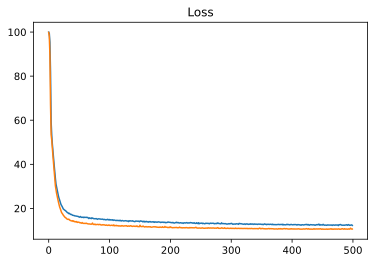

In [140]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show()

In [141]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_1.hdf5')

In [142]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

TEST mape: 10.63%


In [143]:
sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = sub_predict_nn1[:, 0]
sample_submission.to_csv('nn1_submission.csv', index=False)

Рекомендации для улучшения Model 3:    
* В нейросеть желательно подавать данные с распределением, близким к нормальному, поэтому от некоторых числовых признаков имеет смысл взять логарифм перед нормализацией. Пример:
`modelDateNorm = np.log(2020 - data['modelDate'])`
Статья по теме: https://habr.com/ru/company/ods/blog/325422

* Извлечение числовых значений из текста:
Парсинг признаков 'engineDisplacement', 'enginePower', 'Владение' для извлечения числовых значений.

* Cокращение размерности категориальных признаков
Признак name 'name' содержит данные, которые уже есть в других столбцах ('enginePower', 'engineDisplacement', 'vehicleTransmission'), поэтому эти данные можно удалить. Затем следует еще сильнее сократить размерность, например, выделив наличие xDrive в качестве отдельного признака.

# Model 4: NLP + Multiple Inputs

In [144]:
data.description

0       всем привет!\n\nпродам эксклюзивный проект 124...
1       продаю любимейшую тачилу.. обвес и тюнинг hamm...
2       машина тут продаётся не в первый раз, но! толь...
3       автомобиль в отличном состоянии, весь в родной...
4       немка! с бесключивым доступом и камерой заднег...
                              ...                        
8348    продаётся любимый автомобиль! за годы эксплуат...
8349    куплена у официального дилера в 2017 г. \n\nтр...
8350    торг на месте. все работает. сборка немецкая. ...
8351    автомобиль в отличном состоянии.\n3-из авто в ...
8352    удлиненный заводской pullman на базе w140 (воо...
Name: description, Length: 8353, dtype: object

In [145]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [146]:
# split данных
# text_train = data_2.description.iloc[X_train.index]
# text_test = data_2.description.iloc[X_test.index]
# text_sub = data_2.description.iloc[X_sub.index]

**Обработка текста**

In [147]:
!pip install pymorphy2
!pip install pymorphy2-dicts

     |████████████████████████████████| 55 kB 720 kB/s 
     |████████████████████████████████| 8.2 MB 1.6 MB/s 
     |████████████████████████████████| 7.1 MB 913 kB/s 


In [148]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pymorphy2
import nltk
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('russian'))

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [149]:
def pos(word, morth=pymorphy2.MorphAnalyzer()):
    "Return a likely part of speech for the *word*."""
    return morth.parse(word)[0].tag.POS


functors_pos = {'INTJ', 'CONJ', 'PREP'}  # function words

In [150]:
% % time
data.description = data.description.apply(lambda x: " ".join(
    [word for word in x.split() if pos(word) not in functors_pos]))

CPU times: user 4min 39s, sys: 107 ms, total: 4min 39s
Wall time: 4min 41s


In [151]:
# лемматизация
morph = pymorphy2.MorphAnalyzer()
data_NLP = data.copy()

patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+●•✅☑️☛"


def lemmatize(doc):
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        token = token.strip()
        token = morph.normal_forms(token)[0]
        tokens.append(token)
    return ' '.join(tokens)

In [152]:
% % time
data['description'] = data_NLP.apply(
    lambda data_NLP: lemmatize(data_NLP.description), axis=1)

CPU times: user 2min 45s, sys: 208 ms, total: 2min 45s
Wall time: 2min 47s


In [153]:
# split данных
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

### Tokenizer

In [154]:
%% time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

CPU times: user 1.22 s, sys: 5.91 ms, total: 1.23 s
Wall time: 1.23 s


In [155]:
tokenize.word_index

{'•': 1,
 'автомобиль': 2,
 'не': 3,
 'система': 4,
 'задний': 5,
 'всё': 6,
 'пробег': 7,
 'салон': 8,
 'сидение': 9,
 'передний': 10,
 'машина': 11,
 '2': 12,
 'комплект': 13,
 'год': 14,
 'официальный': 15,
 'ваш': 16,
 'кредит': 17,
 'вы': 18,
 'диск': 19,
 'новый': 20,
 'авто': 21,
 'состояние': 22,
 'пакет': 23,
 'фара': 24,
 'безопасность': 25,
 'руль': 26,
 'колесо': 27,
 'дилер': 28,
 'гарантия': 29,
 'состоянии': 30,
 'птс': 31,
 'обмен': 32,
 'контроль': 33,
 'комплектация': 34,
 'bmw': 35,
 'быть': 36,
 '000': 37,
 'два': 38,
 'более': 39,
 'полный': 40,
 'весь': 41,
 'покупка': 42,
 'зеркало': 43,
 'датчик': 44,
 '1': 45,
 'есть': 46,
 'только': 47,
 'мы': 48,
 'продажа': 49,
 'отличный': 50,
 'автомобиля': 51,
 'один': 52,
 'водитель': 53,
 'подушка': 54,
 'шина': 55,
 'пассажир': 56,
 '6': 57,
 'двигатель': 58,
 'хороший': 59,
 'подогрев': 60,
 'км': 61,
 'любой': 62,
 '3': 63,
 'обогрев': 64,
 'юридический': 65,
 'проверка': 66,
 'обслуживание': 67,
 'технический': 68,


In [156]:
% % time
text_train_sequences = sequence.pad_sequences(
    tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(
    tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(
    tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape,
      text_test_sequences.shape, text_sub_sequences.shape, )

(5679, 256) (1003, 256) (1671, 256)
CPU times: user 1.25 s, sys: 3.91 ms, total: 1.25 s
Wall time: 1.25 s


In [157]:
# вот так теперь выглядит наш текст
print(text_train.iloc[6])
print(text_train_sequences[6])

. • автомобиль проверить 110 пункт • автокредит специальный ставка 13,7% ауди центр север, официальный дилер audi, входящий группа компания рольф являться один крупный дилер европе, предлагать вы ряд услуга покупка продажа автомобиль пробегом. протяжение многий год наш дилерский центр являться лидер продажа автомобиль пробег весь дилер audi россия предоставлять клиент самый большой выбор автомобиль пробег audi другой марок. каждый автомобиль проходить тщательный диагностик подготовку, гарантировать находиться отличный состоянии. убедиться правильный выборе, вы есть возможность пройти тест-драйв ― ознакомительный поездка интересовать автомобиле. вы смочь ознакомиться автомобиль не выходить дом – наш менеджер провести online презентация видеозвонок показать выбрать автомобиль. также ауди центр север представлять уникальный предложение кредитование автомобиль пробег индивидуальный условиях. специалист компания подобрать вы хороший условие кредитования. более 6 000 проверить автомобиль про

### RNN NLP

In [158]:
# Изначальный вариант

model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

### MLP

In [159]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

### Multiple Inputs NN

In [160]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [161]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 256)     8118528     seq_description[0][0]            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 256, 256)     525312      embedding[0][0]                  
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 256, 256)     0           lstm[0][0]                       
______________________________________________________________________________________________

### Fit

In [162]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE', optimizer=optimizer, metrics=['MAPE'])

In [163]:
checkpoint = ModelCheckpoint(
    '../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(
    monitor='val_MAPE', patience=10, restore_best_weights=True,)
# RLRP = ReduceLROnPlateau(monitor='val_mape', patience=40, factor=0.1)
callbacks_list = [checkpoint, earlystop]

In [164]:
%% time
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=500,  # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                    )

Epoch 1/500


2021-10-25 13:00:29.802783: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


12/12 [==============================] - 7s 207ms/step - loss: 99.9497 - MAPE: 99.9497 - val_loss: 99.4101 - val_MAPE: 99.4101
Epoch 2/500
12/12 [==============================] - 2s 154ms/step - loss: 95.2182 - MAPE: 95.2182 - val_loss: 79.5912 - val_MAPE: 79.5912
Epoch 3/500
12/12 [==============================] - 2s 154ms/step - loss: 62.7764 - MAPE: 62.7764 - val_loss: 57.7562 - val_MAPE: 57.7562
Epoch 4/500
12/12 [==============================] - 2s 155ms/step - loss: 50.9472 - MAPE: 50.9472 - val_loss: 47.5578 - val_MAPE: 47.5578
Epoch 5/500
12/12 [==============================] - 2s 155ms/step - loss: 43.8747 - MAPE: 43.8747 - val_loss: 38.8948 - val_MAPE: 38.8948
Epoch 6/500
12/12 [==============================] - 2s 154ms/step - loss: 36.4733 - MAPE: 36.4733 - val_loss: 31.8623 - val_MAPE: 31.8623
Epoch 7/500
12/12 [==============================] - 2s 154ms/step - loss: 30.9941 - MAPE: 30.9941 - val_loss: 28.0233 - val_MAPE: 28.0233
Epoch 8/500
12/12 [====================

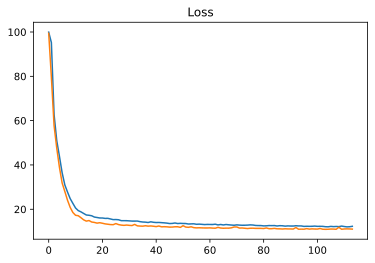

In [165]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show()

In [166]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_mlp_nlp.hdf5')

In [167]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

TEST mape: 11.03%


In [168]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
sample_submission['price'] = sub_predict_nn2[:, 0]
sample_submission.to_csv('nn2_submission.csv', index=False)

Идеи для улучшения NLP части:
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например, сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста

In [169]:
blend_predict = (test_predict_catboost + test_predict_nn2[:, 0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 10.58%


In [170]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn2[:, 0]) / 2

# Model 5: Добавляем картинки

### Data

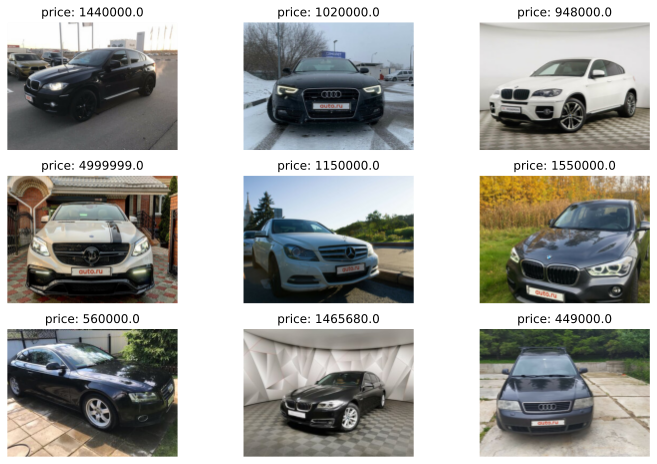

In [171]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize=(12, 8))

random_image = train.sample(n=9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [172]:
%% time

size = (320, 240)


def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)


images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5679, 240, 320, 3) dtype uint8
images shape (1003, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8
CPU times: user 11.1 s, sys: 3.81 s, total: 14.9 s
Wall time: 1min 17s


### albumentations

/opt/conda/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:290: FutureWarning: This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead
  warnings.warn("This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead", FutureWarning)
/opt/conda/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:222: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/opt/conda/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:165: FutureWarning: This augmentation is deprecated. Please use Emboss instead
  warnings.warn("This augmentation is deprecated. Please use Emboss instead", FutureWarning)


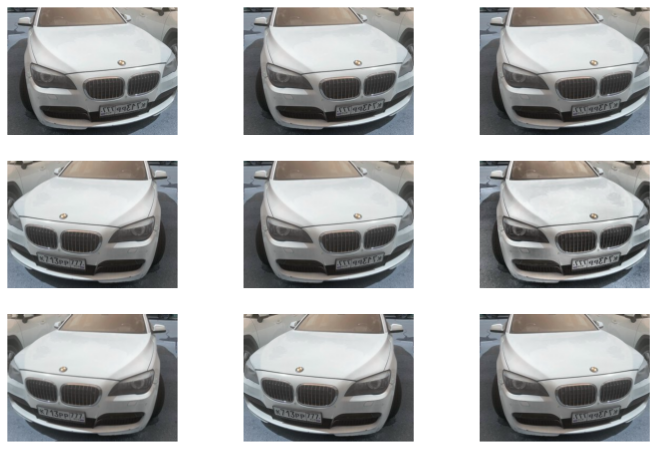

In [173]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90, Transpose,
    ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)

'''
#пример взят из официальной документации: https://albumentations.readthedocs.io/en/latest/examples.html

augmentation = Compose([
    HorizontalFlip(),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.2),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=1),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
        IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(),
    ], p=0.3),
    HueSaturationValue(p=0.3),
], p=1)

#пример
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation(image = images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()
'''

# augmentation = Compose([HorizontalFlip(p=0.5), ShiftScaleRotate(p=0.5)])
# augmentation = Compose(HorizontalFlip(p=0.5))
augmentation = Compose([HorizontalFlip(p=0.5),
                        OneOf([
                            OpticalDistortion(p=0.3),
                            GridDistortion(p=0.1),
                            IAAPiecewiseAffine(p=0.3),
                        ], p=0.2),
                        OneOf([
                            CLAHE(clip_limit=2),
                            IAASharpen(),
                            IAAEmboss(),
                            RandomBrightnessContrast(),
                        ], p=0.3)
                        ])

# пример
plt.figure(figsize=(12, 8))
for i in range(9):
    img = augmentation(image=images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [174]:
def make_augmentations(images):
    print('применение аугментаций', end='')
    augmented_images = np.empty(images.shape)
    for i in range(images.shape[0]):
        if i % 200 == 0:
            print('.', end='')
        augment_dict = augmentation(image=images[i])
        augmented_image = augment_dict['image']
        augmented_images[i] = augmented_image
    print('')
    return augmented_images

## tf.data.Dataset
Если все изображения мы будем хранить в памяти, то может возникнуть проблема ее нехватки. Не храните все изображения в памяти целиком!

Метод .fit() модели keras может принимать либо данные в виде массивов или тензоров, либо разного рода итераторы, из которых наиболее современным и гибким является [tf.data.Dataset](https://www.tensorflow.org/guide/data). Он представляет собой конвейер, то есть мы указываем, откуда берем данные и какую цепочку преобразований с ними выполняем. Далее мы будем работать с tf.data.Dataset.

Dataset хранит информацию о конечном или бесконечном наборе кортежей (tuple) с данными и может возвращать эти наборы по очереди. Например, данными могут быть пары (input, target) для обучения нейросети. С данными можно осуществлять преобразования, которые осуществляются по мере необходимости ([lazy evaluation](https://ru.wikipedia.org/wiki/%D0%9B%D0%B5%D0%BD%D0%B8%D0%B2%D1%8B%D0%B5_%D0%B2%D1%8B%D1%87%D0%B8%D1%81%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F)).

`tf.data.Dataset.from_tensor_slices(data)` - создает датасет из данных, которые представляют собой либо массив, либо кортеж из массивов. Деление осуществляется по первому индексу каждого массива. Например, если `data = (np.zeros((128, 256, 256)), np.zeros(128))`, то датасет будет содержать 128 элементов, каждый из которых содержит один массив 256x256 и одно число.

`dataset2 = dataset1.map(func)` - применение функции к датасету; функция должна принимать столько аргументов, каков размер кортежа в датасете 1 и возвращать столько, сколько нужно иметь в датасете 2. Пусть, например, датасет содержит изображения и метки, а нам нужно создать датасет только из изображений, тогда мы напишем так: `dataset2 = dataset.map(lambda img, label: img)`.

`dataset2 = dataset1.batch(8)` - группировка по батчам; если датасет 2 должен вернуть один элемент, то он берет из датасета 1 восемь элементов, склеивает их (нулевой индекс результата - номер элемента) и возвращает.

`dataset.__iter__()` - превращение датасета в итератор, из которого можно получать элементы методом `.__next__()`. Итератор, в отличие от самого датасета, хранит позицию текущего элемента. Можно также перебирать датасет циклом for.

`dataset2 = dataset1.repeat(X)` - датасет 2 будет повторять датасет 1 X раз.

Если нам нужно взять из датасета 1000 элементов и использовать их как тестовые, а остальные как обучающие, то мы напишем так:

`test_dataset = dataset.take(1000)
train_dataset = dataset.skip(1000)`

Датасет по сути неизменен: такие операции, как map, batch, repeat, take, skip никак не затрагивают оригинальный датасет. Если датасет хранит элементы [1, 2, 3], то выполнив 3 раза подряд функцию dataset.take(1) мы получим 3 новых датасета, каждый из которых вернет число 1. Если же мы выполним функцию dataset.skip(1), мы получим датасет, возвращающий числа [2, 3], но исходный датасет все равно будет возвращать [1, 2, 3] каждый раз, когда мы его перебираем.

tf.Dataset всегда выполняется в graph-режиме (в противоположность eager-режиму), поэтому либо преобразования (`.map()`) должны содержать только tensorflow-функции, либо мы должны использовать tf.py_function в качестве обертки для функций, вызываемых в `.map()`. Подробнее можно прочитать [здесь](https://www.tensorflow.org/guide/data#applying_arbitrary_python_logic).

In [175]:
# NLP part
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

In [176]:
def process_image(image):
    return augmentation(image=image.numpy())['image']


def tokenize_(descriptions):
    return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen=MAX_SEQUENCE_LENGTH)


def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]


def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image, ] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text, ] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price


def tf_process_val_dataset_element(image, table_data, text, price):
    [text, ] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price


train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data.description.iloc[X_train.index], y_train
)).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data.description.iloc[X_test.index], y_test
)).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data.description.iloc[X_sub.index], y_sub
)).map(tf_process_val_dataset_element)

# проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__()
test_dataset.__iter__().__next__()
sub_dataset.__iter__().__next__()

2021-10-25 13:06:41.994185: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1308441600 exceeds 10% of free system memory.
2021-10-25 13:06:43.398759: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1308441600 exceeds 10% of free system memory.
2021-10-25 13:06:45.625319: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1308441600 exceeds 10% of free system memory.
2021-10-25 13:06:46.730679: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-10-25 13:06:47.035413: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


### Строим сверточную сеть для анализа изображений без "головы"

In [177]:
# нормализация включена в состав модели EfficientNetB3, поэтому на вход она принимает данные типа uint8
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(
    weights='imagenet', include_top=False, input_shape=(size[1], size[0], 3))
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

43950080/43941136 [==============================] - 0s 0us/step


In [178]:
# строим нейросеть для анализа табличных данных

tabular_model = Sequential([
    L.Input(shape=X.shape[1]),
    L.Dense(512, activation='relu'),
    L.Dropout(0.5),
    L.Dense(256, activation='relu'),
    L.Dropout(0.5),
])

In [179]:
'''
#строим нейросеть для анализа табличных данных

tabular_model = Sequential([
    L.Input(shape = X.shape[1]),
    L.Dense(512, input_dim=X_train.shape[1], kernel_regularizer=regularizers.l1_l2(l1=0.000000001, 
        l2=0.000000001), activation="relu"),
    L.Dropout(0.5),
    L.Dense(256, kernel_regularizer=regularizers.l1_l2(l1=0.000000001, 
        l2=0.000000001), activation="relu"),
    L.Dropout(0.5),
    L.Dense(1, activation="linear")
    ])
'''

'\n#строим нейросеть для анализа табличных данных\n\ntabular_model = Sequential([\n    L.Input(shape = X.shape[1]),\n    L.Dense(512, input_dim=X_train.shape[1], kernel_regularizer=regularizers.l1_l2(l1=0.000000001, \n        l2=0.000000001), activation="relu"),\n    L.Dropout(0.5),\n    L.Dense(256, kernel_regularizer=regularizers.l1_l2(l1=0.000000001, \n        l2=0.000000001), activation="relu"),\n    L.Dropout(0.5),\n    L.Dense(1, activation="linear")\n    ])\n'

In [180]:
# NLP
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.LSTM(128),
    L.Dropout(0.25),
    L.Dense(64),
])

In [181]:
# объединяем выходы трех нейросетей
combinedInput = L.concatenate(
    [efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input,
                      tabular_model.input, nlp_model.input], outputs=head)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 240, 320, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 240, 320, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 321, 3)  0           normalization[0][0]              
____________________________________________________________________________________________

In [182]:
optimizer = tf.keras.optimizers.Adam(0.005)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [183]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [184]:
%% time
history = model.fit(train_dataset.batch(30),
                    epochs=100,
                    validation_data=test_dataset.batch(30),
                    callbacks=callbacks_list
                    )

2021-10-25 13:07:07.324424: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1308441600 exceeds 10% of free system memory.
2021-10-25 13:07:08.120662: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1308441600 exceeds 10% of free system memory.


Epoch 1/100
190/190 [==============================] - 206s 976ms/step - loss: 45.5114 - MAPE: 45.5114 - val_loss: 18.9401 - val_MAPE: 18.9401


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
190/190 [==============================] - 182s 957ms/step - loss: 19.3122 - MAPE: 19.3122 - val_loss: 14.9039 - val_MAPE: 14.9039
Epoch 3/100
190/190 [==============================] - 182s 958ms/step - loss: 16.9269 - MAPE: 16.9269 - val_loss: 13.8654 - val_MAPE: 13.8654
Epoch 4/100
190/190 [==============================] - 184s 970ms/step - loss: 15.9739 - MAPE: 15.9739 - val_loss: 13.4802 - val_MAPE: 13.4802
Epoch 5/100
190/190 [==============================] - 181s 954ms/step - loss: 15.2216 - MAPE: 15.2216 - val_loss: 12.9967 - val_MAPE: 12.9967
Epoch 6/100
190/190 [==============================] - 182s 954ms/step - loss: 14.9144 - MAPE: 14.9144 - val_loss: 12.7187 - val_MAPE: 12.7187
Epoch 7/100
190/190 [==============================] - 183s 960ms/step - loss: 14.6507 - MAPE: 14.6507 - val_loss: 12.7577 - val_MAPE: 12.7577
Epoch 8/100
190/190 [==============================] - 187s 980ms/step - loss: 14.0805 - MAPE: 14.0805 - val_loss: 12.2664 - val_MAPE: 12.2664

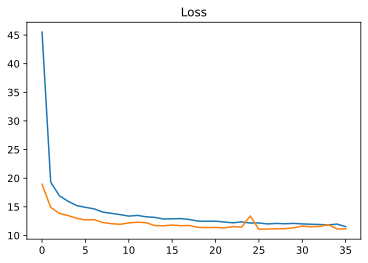

In [185]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show()

In [186]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_final.hdf5')

In [187]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

TEST mape: 11.17%


In [188]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30))
sample_submission['price'] = sub_predict_nn3[:, 0]
sample_submission.to_csv('nn3_submission.csv', index=False)


#### Общие рекомендации:
* Попробовать разные архитектуры
* Провести более детальный анализ результатов
* Попробовать различные подходы в управление LR и оптимизаторы
* Поработать с таргетом
* Использовать Fine-tuning

#### Tabular
* В нейросеть желательно подавать данные с распределением, близким к нормальному, поэтому от некоторых числовых признаков имеет смысл взять логарифм перед нормализацией. Пример:
`modelDateNorm = np.log(2020 - data['modelDate'])`
Статья по теме: https://habr.com/ru/company/ods/blog/325422

* Извлечение числовых значений из текста:
Парсинг признаков 'engineDisplacement', 'enginePower', 'Владение' для извлечения числовых значений.

* Cокращение размерности категориальных признаков
Признак name 'name' содержит данные, которые уже есть в других столбцах ('enginePower', 'engineDisplacement', 'vehicleTransmission'). Можно удалить эти данные. Затем можно еще сильнее сократить размерность, например выделив наличие xDrive в качестве отдельного признака.

* Поработать над Feature engineering



#### NLP
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста



#### CV
* Попробовать различные аугментации
* Fine-tuning

# Blend

In [189]:
blend_predict = (test_predict_catboost + test_predict_nn3[:, 0]) / 2
# blend_predict = (test_predict_catboost + test_predict_nn3[:,0] + test_predict_nn2[:,0] + test_predict_nn1[:,0])/4
# blend_predict = (test_predict_catboost + test_predict_nn2[:,0] + test_predict_nn1[:,0])/3
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 10.69%


In [190]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn3[:, 0]) / 2
# blend_sub_predict = (sub_predict_nn2[:,0] + sub_predict_nn3[:,0] + sub_predict_catboost + sub_predict_nn1[:,0])/4
# blend_sub_predict = (sub_predict_nn2[:,0] + sub_predict_catboost + sub_predict_nn1[:,0])/3
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission.csv', index=False)

# Выводы:

В этой работе основная задача пришлась на подготовку, анализ и обработку данных. Сделано описание признаков, работа снабжена комментариями. Целевая переменная исследована и для одной из моделей логарифмирована для сокращения количества выбросов. Для каждой модели данные подаются отдельно (состав признаков, обработка), что позволяет достичь лучших результатов. Для поля "Описание" была проведена лемматизация и частичная очистка от служебных слов. Для изображений приведена аугментация на основе приведенного примера (дополнен новыми фичами). Были изменена структура первой нейросети (для табличных данных). К сожалению, применение этого решения в дальнейшем сильно тормозило обучение и не сказывалось на результате в положительную сторону.

Блендирование показало достаточно хорошие результаты как на тестовых, так и на живых данных.

В отдельных ноутбуках проведены эксперименты с другими моделями: xb - результат на тесте недостаточно хорош, catboost умеет лучше. На LightAutoML (тестовая MAPE 11.52) не хватило ускорителя.

Лучших результатов можно было достичь за счет более тщательной очистки признака description, дополнительной аугментации картинок и более пристального внимания к структуре нейросети.

Выводы личного характера: 

1. Мне больше нравится готовить данные и скармливать их модели, чем изменять саму модель. Видимо, с данными я уже более-менее освоилась, а модели пока еще вызывают опасение. Обработка текста мне проще и интереснее, чем обработка картинок.

2. Очень нервируют ограничения по GPU - но такова жизнь. Никто машинного времени больше, чем есть, не даст. 

3. Нужно тщательнее повторить про сохранение модели и load_weight. Если меньше нервничать и спокойнее относиться к периодам, когда модель учится, а ты нет - работа будет только эффективнее.

# Model Bonus: проброс признака

In [191]:
# MLP
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

In [192]:
# FEATURE Input
# Iput
productiondate = L.Input(shape=[1], name="productiondate")
# Embeddings layers
emb_productiondate = L.Embedding(
    len(X.productionDate.unique().tolist())+1, 20)(productiondate)
f_productiondate = L.Flatten()(emb_productiondate)

In [193]:
combinedInput = L.concatenate([model_mlp.output, f_productiondate, ])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_mlp.input, productiondate], outputs=head)

In [194]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_13_input (InputLayer)     [(None, 217)]        0                                            
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 512)          111616      dense_13_input[0][0]             
__________________________________________________________________________________________________
dropout_11 (Dropout)            (None, 512)          0           dense_13[0][0]                   
__________________________________________________________________________________________________
productiondate (InputLayer)     [(None, 1)]          0                                            
____________________________________________________________________________________________

In [195]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE', optimizer=optimizer, metrics=['MAPE'])

In [196]:
%% time
history = model.fit([X_train, X_train.productionDate.values], y_train,
                    batch_size=512,
                    epochs=500,  # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(
                        [X_test, X_test.productionDate.values], y_test),
                    callbacks=callbacks_list
                    )

Epoch 1/500
12/12 [==============================] - 1s 19ms/step - loss: 99.9534 - MAPE: 99.9534 - val_loss: 99.4885 - val_MAPE: 99.4885
Epoch 2/500
12/12 [==============================] - 0s 5ms/step - loss: 96.0242 - MAPE: 96.0242 - val_loss: 83.0292 - val_MAPE: 83.0292
Epoch 3/500
12/12 [==============================] - 0s 6ms/step - loss: 64.0948 - MAPE: 64.0948 - val_loss: 60.6353 - val_MAPE: 60.6353
Epoch 4/500
12/12 [==============================] - 0s 5ms/step - loss: 52.7471 - MAPE: 52.7471 - val_loss: 48.7393 - val_MAPE: 48.7393
Epoch 5/500
12/12 [==============================] - 0s 7ms/step - loss: 45.4480 - MAPE: 45.4480 - val_loss: 40.7959 - val_MAPE: 40.7959
Epoch 6/500
12/12 [==============================] - 0s 5ms/step - loss: 38.4613 - MAPE: 38.4613 - val_loss: 33.5093 - val_MAPE: 33.5093
Epoch 7/500
12/12 [==============================] - 0s 5ms/step - loss: 32.2866 - MAPE: 32.2866 - val_loss: 28.2321 - val_MAPE: 28.2321
Epoch 8/500
12/12 [=====================

In [197]:
model.load_weights('../working/best_model.hdf5')
test_predict_nn_bonus = model.predict([X_test, X_test.productionDate.values])
print(f"TEST mape: {(mape(y_test, test_predict_nn_bonus[:,0]))*100:0.2f}%")

TEST mape: 10.73%


AutoML

In [198]:
# !pip install lightautoml -q

In [199]:
# Imports from LightAutoML package
# from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
# from lightautoml.tasks import Task

In [200]:
# %%time

# tr_data, valid_data = train_test_split(train_data, test_size=0.2,random_state=42)

In [201]:
# roles = {'target': 'price'}

In [202]:
# def mape_metric(y_true, y_pred):
#    return np.mean(np.abs((y_pred-y_true)/y_true))

# task = Task('reg', metric=mape_metric,greater_is_better=False,loss='mape')

In [203]:
'''
automl = TabularAutoML(task = task, 
                       timeout = 600, # 600 seconds = 10 minutes
                       cpu_limit = 4, # Optimal for Kaggle kernels
                       general_params = {'use_algos': [['linear_l2', 
                                         'lgb', 'lgb_tuned']]})
'''

"\nautoml = TabularAutoML(task = task, \n                       timeout = 600, # 600 seconds = 10 minutes\n                       cpu_limit = 4, # Optimal for Kaggle kernels\n                       general_params = {'use_algos': [['linear_l2', \n                                         'lgb', 'lgb_tuned']]})\n"

In [204]:
# oof_pred = automl.fit_predict(tr_data, roles = roles)

In [205]:
# valid_pred = automl.predict(valid_data)

In [206]:
# print('OOF mape: {}'.format(mape_metric(tr_data['price'].values,      oof_pred.data[:, 0])))
# print('VAL mape: {}'.format(mape_metric(valid_data['price'].values, valid_pred.data[:, 0])))

In [207]:
'''
automl = TabularUtilizedAutoML(task = task, 
                       timeout = 600, # 600 seconds = 10 minutes
                       cpu_limit = 4, # Optimal for Kaggle kernels
                       general_params = {'use_algos': [['linear_l2', 
                                         'lgb', 'lgb_tuned']]})
'''

"\nautoml = TabularUtilizedAutoML(task = task, \n                       timeout = 600, # 600 seconds = 10 minutes\n                       cpu_limit = 4, # Optimal for Kaggle kernels\n                       general_params = {'use_algos': [['linear_l2', \n                                         'lgb', 'lgb_tuned']]})\n"

In [208]:
# %%time
# oof_pred = automl.fit_predict(tr_data, roles = roles)

In [209]:
# valid_pred = automl.predict(valid_data)

In [210]:
# print('OOF mape: {}'.format(mape_metric(tr_data['price'].values,      oof_pred.data[:, 0])))
# print('VAL mape: {}'.format(mape_metric(valid_data['price'].values, valid_pred.data[:, 0])))

In [211]:
'''
automl = TabularUtilizedAutoML(task = task, 
                       timeout = 10800, # 3 hour,  default 3600 seconds
                       cpu_limit = 4, # Optimal for Kaggle kernels
                       general_params = {'use_algos': [['linear_l2', 
                                         'lgb', 'lgb_tuned']]})
oof_pred = automl.fit_predict(train_data, roles = roles)
test_pred = automl.predict(test_data)
'''

"\nautoml = TabularUtilizedAutoML(task = task, \n                       timeout = 10800, # 3 hour,  default 3600 seconds\n                       cpu_limit = 4, # Optimal for Kaggle kernels\n                       general_params = {'use_algos': [['linear_l2', \n                                         'lgb', 'lgb_tuned']]})\noof_pred = automl.fit_predict(train_data, roles = roles)\ntest_pred = automl.predict(test_data)\n"

In [212]:
# submission['price'] = (test_pred.data[:, 0]).astype(int)
# submission.to_csv('automl_mape_submission.csv', index = False)

In [213]:
# 